In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import pymadx
from xcoll_plotting import plot_functions as xcp

No pytransport functionality
No pytransport functionality


In [2]:
# SPECIFIC CONVERSION FUNCTIONS 

def change_coordinates_to_b1(df, end_s=26658.883171485748):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df


def reset_coord_cry_tracking(df, twiss):
    df['s'] = np.where(df['s'] <=  end_s-TCCS_loc, end_s-TCCS_loc-df['s'], 2*end_s-TCCS_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == TCCS_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def extract_channelled(df):
    df = df.loc[(df['s']<end_s-TCCS_loc) & (df['s']>end_s-TCLA_loc)]
    return df


def filter_aperture_rotations(df, line):    
    aperture_offsets = []
    for name, element in line.element_dict.items():
        if '_tilt_entry' in name and element.__class__.__name__.startswith('SRotation'):
            aper_name = name.split('_tilt')[0]
            aperture_offsets.append(aper_name)#[aper_name] = (element.s)

    return df[~df['name'].str.contains('|'.join(aperture_offsets), case=False)]

In [3]:
# STANDARD CONVERSION FUNCTIONS

def _norm_to_geom_emittance(norm_emittance, E0, E):
    betagamma = _calc_betagamma(E0, E)
    return norm_emittance / betagamma

def _calc_betagamma(E0, E):
    gamma = float(E)/E0
    beta = np.sqrt(1.-(1./gamma)**2)
    return beta*gamma

def rad_to_deg(n):
    return n*180/np.pi

def convert_m_to_mm(val):
    return val / 1e-3

def convert_mm_to_m(val):
    return val * 1e-3



In [4]:
# LOAD COLLIMATORS FUNCTIONS

def add_collimator_halfgap(coll_df, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy):
        
    # Calculate the geometric emittances first
    emit_geom_x = _norm_to_geom_emittance(nemitt_x, reference_mass, reference_energy)
    emit_geom_y = _norm_to_geom_emittance(nemitt_y, reference_mass, reference_energy)

    openings = []
    sigmas_x = []
    sigmas_y = []
    for name, parameters in coll_df.iterrows():
        betx = parameters["betx"]
        bety = parameters["bety"]

        nsigma = parameters["gap"]
        angle  = parameters["angle"]

        sigma_x = np.sqrt(betx * emit_geom_x)
        sigma_y = np.sqrt(bety * emit_geom_y)

        a = nsigma * sigma_x
        b = nsigma * sigma_y

        x = a * np.cos(angle)
        y = b * np.sin(angle)

        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        openings.append(np.sqrt(x**2 + y**2))

    coll_df['sigma_x'] = sigmas_x
    coll_df['sigma_y'] = sigmas_y
    coll_df['opening'] = openings
    


def load_coll_yaml(filename, optics_df, reference_mass, reference_energy,
                          nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, beam = 2):
    
    # load collimators form yaml file as pandas
    with open(filename, 'r') as file:
           collimators = yaml.safe_load(file)   
    coll_dict  = collimators['collimators'][f'b{beam}']
    df = pd.DataFrame.from_dict(coll_dict, orient="index")
    df = df.rename_axis('name').reset_index()
    coll_list = df['name'].to_list()
    
    # merge it with dataframe from twiss
    df_col_twiss = optics_df[optics_df['name'].isin(coll_list)]
    df_coll_tot = pd.merge(df, df_col_twiss, on="name")
    
    add_collimator_halfgap(df_coll_tot, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy)
    return df_coll_tot

In [5]:
# PLOT COLLIMATORS 

def plot_collimators(coll_data, ax, plane, df_twiss, df_chann, plot_offplane_coll = True):

    coll_data = change_coordinates_to_b1(coll_data)


    hors = (coll_data['angle'] <  rad_to_deg(0.1)) | (coll_data['angle'] >  rad_to_deg(6.1))
    vers = (coll_data['angle'] >  rad_to_deg(1.5)) & (coll_data['angle'] <  rad_to_deg(1.6))


    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]
    


    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s"]
        hgap    = coll["opening"]

        if(coll['name'] == TCCS_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCS_name]['s'])
            hgap = df_twiss[df_twiss['s'] == s_centre]['5_sigma_y'].iloc[0]
        elif(coll['name'] == TCCP_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCP_name]['s'])
            hgap = df_chann[df_chann['s'] == s_centre]['y'].iloc[0]
        elif(coll['name'] == TARGET_name):
            continue


        orbit = coll['x'] if plane=='h' else coll['y']
        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        
        
        if coll['side'] == 'left':
            color = 'r' if not pd.isna(coll['crystal']) else 'k'
            jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw, zorder=10)
            ax.add_patch(jaw)

        elif coll['side'] == 'right': 
            color = 'r' if not pd.isna(coll['crystal']) else 'k'      
            jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw,  zorder=10)
            ax.add_patch(jaw)
            
        else:
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)
            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)


    if plot_offplane_coll:
        for index, coll in off_plane_collimators.iterrows():
            s_centre = coll["s"]
            sstart  = s_centre - coll["length"]/2
            send    = s_centre + coll["length"]/2
            orbit = coll['x'] if plane=='h' else coll['y']

            alpha = 1
            color = 'slategray'
            edcgecolor = 'slategray'

            coll_angle = coll['angle']
            coll_opening = coll['opening']
            if plane == 'h':
                hgap = (coll_opening / np.abs(np.cos(coll_angle)) 
                        if not np.isclose(np.cos(coll_angle), 0) else np.inf)
            elif plane == 'v':
                hgap = (coll_opening/ np.abs(np.sin(coll_angle)) 
                        if not np.isclose(np.sin(coll_angle), 0) else np.inf)

            if np.isnan(hgap) or hgap > 0.900:
                hgap = 0 # Closed bars for non-cut collimators
                alpha = 1
                color = 'lightgray'
                edcgecolor = 'lightgray'

            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2
            h       = top_lim - hgap
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)
            
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0,
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)

            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)

In [6]:
# PLOT 

def plot_IR3(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, df_coll=None, s_start=6300, s_stop=7100):
    
    plot_axis.plot(df_ref["s"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s"],df_ref["5_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s"],-df_ref["5_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s"], df_ref["5_sigma_y"], -df_ref["5_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=17)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=17)
    plot_axis.grid(linestyle=':')
    
    
    plot_axis.tick_params(axis='both', which='major', labelsize=15)
    
    plot_axis.text(end_s - TCCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCLA_loc, max(plot_axis.get_yticks())+0.0008, "TCLA", horizontalalignment='center', fontsize=17)

    # convert, xcp function handles dataframe in m
    xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), plot_axis, "v")
    
    if df_coll is not None:
        plot_collimators(df_coll, plot_axis, "v", df_ref, df_chann, plot_offplane_coll = True)

# Load and Set-up

In [20]:
## Choose a context
context = xo.ContextCpu()         # For CPU


layout_file = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)


TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'

pymadx.Tfs.Load> normal file


In [26]:
Run3 = './input_files/2024_Run3_flat_top/flat_top_b2.json'
#HL_rematched_IR3_IR7 = './input_files/HL_IR7_IR3_rematched/b4_sequence_patched.json'
HL_rem_IR7_phadv = './input_files/HL_phase_scan/b4_sequence_patched_phadv_105.json'
HL_rem_IR7_tune = './input_files/HL_IR7_tune_changed/b4_sequence_patched_tune.json'
coll_file_HL = "./input_files/colldbs/HL_tight_twocryst.yaml"
#coll_file_Run3 = "./input_files/colldbs/flat_top.data"

In [27]:
def load_line(line_path, coll_path, B = 'B2'):


    line = xt.Line.from_json(line_path)
    coll_file = coll_path

    end_s = line.get_length()

    if B == 'B2':
        TCCS_loc = end_s - 6773.7 #6775
        TCCP_loc = end_s - 6653.3 #6655
        TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2)
        TCLA_loc = line.get_s_position(TCLA_name)
    elif B == 'B1':
        TCCS_loc = 6773.7
        TCCP_loc = 6653.3
        TARGET_loc = (6653.3 + 0.07/2 +0.005/2)
        #TCLA_loc = line.get_s_position(TCLA_name)

    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name = TCCS_name)
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCS_name + '_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCP_name + '_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TARGET_name + '_aper')

    
    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])

    twiss = line.twiss(method = '4d')

    df_apertures = xcp.load_apertures(line)
    df_apertures = change_coordinates_to_b1(df_apertures, end_s)

    return twiss, df_apertures, line

In [28]:
twiss, df_apertures, line = load_line(HL_rem_IR7_tune, coll_file_HL)

Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/151124 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/151127 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/151130 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker


In [29]:
twiss_ph, df_apertures_ph, line_ph = load_line(HL_rem_IR7_phadv, coll_file_HL)

Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/151124 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/151127 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/151130 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker


In [30]:
df=twiss_ph.to_pandas()

In [31]:
df.query('name=="ip2"')['alfx']

132405   -0.062431
Name: alfx, dtype: float64

In [32]:
df_tune = twiss.to_pandas()
df_tune = change_coordinates_to_b1(df_tune, line.get_length()) 
df_tune = filter_aperture_rotations(df_tune, line)

In [33]:
df_phase= twiss_ph.to_pandas()
df_phase = change_coordinates_to_b1(df_phase, line_ph.get_length())
df_phase = filter_aperture_rotations(df_phase, line_ph)

In [34]:
IR1_s = 26658.883171485748 #df_tune[df_tune['name']=='ip1']['s'].values[0]
IR2_s = 3332.2842159531574 #df_tune[df_tune['name']=='ip2']['s'].values[0]
IR3_s = 6664.720795520017 #df_tune[df_tune['name']=='ip3']['s'].values[0]
IR4_s = 9997.157370581852 #df_tune[df_tune['name']=='ip4']['s'].values[0]
IR5_s = 13329.593944863704 #df_tune[df_tune['name']=='ip5']['s'].values[0]
IR6_s = 16661.878161189652 # df_tune[df_tune['name']=='ip6']['s'].values[0]
IR7_s = 19994.162375198746 # df_tune[df_tune['name']=='ip7']['s'].values[0]
IR8_s = 23315.226589021902 #df_tune[df_tune['name']=='ip8']['s'].values[0]

In [35]:
def compare_ip(df1, df2, IP_s,N = 1000, y_lim = 1300, end_s=26658.883171485748, return_fig=False):
    TCCS_loc = end_s - 6773.7 #6775
    s_start = IP_s - N #19000#6300
    s_stop = IP_s + N #21000#7100
    fig, ax = plt.subplots(1, 1, figsize=(13,8))
    #pymadx.Plot._SetMachineAxesStyle(plot_axis[0])
    #pymadx.Plot._DrawMachineLattice(plot_axis[0], layout_data_object)
    ax.set_xlim(s_start,s_stop)
    ax.plot(df1["s"],df1["bety"],color="orange", label=r'$\beta_y$ nominal')
    ax.plot(df2["s"],df2["bety"],color="orange", linestyle='--', label=r'$\beta_y$ modified')
    ph_adv = True
    if ph_adv:
        d_ax = ax.twinx()
        mux_1 = (df1['muy'] % 1 *2*np.pi*180/np.pi).to_list()
        mux_2 = (df2['muy'] % 1 *2*np.pi*180/np.pi).to_list()
        d_ax.plot(df1["s"], mux_1,color="green", label=r'$\mu_y$ nominal')
        d_ax.plot(df2["s"], mux_2,color="green", linestyle='--', label=r'$\mu_y$ modified')
        d_ax.set_ylabel(r'$\mu$[deg]',  fontsize=17)
        d_ax.tick_params(axis='both', which='major', labelsize=15)

    #plot_axis[1].set_ylim(-10, 400)
    ax.set_ylim(-10, y_lim)
    #plot_axis[1].set_ylim(-10, 400)

    ax.set_xlabel('s [m]',  fontsize=17)
    ax.set_xlim(s_start, s_stop)
    ax.set_ylabel('y [m]',  fontsize=17)
    
    ax.grid(linestyle=':')

    n=-10

    ax.tick_params(axis='both', which='major', labelsize=15)
   
    #ax.text(end_s - TCCS_loc, max(plot_axis[1].get_yticks())+n, "TCCS", horizontalalignment='center', fontsize=17)
    #ax.text(end_s - TCCP_loc, max(plot_axis[1].get_yticks())+n, "TCCP", horizontalalignment='center', fontsize=17)
    #ax.text(end_s - TCLA_loc, max(plot_axis[1].get_yticks())+n, "TCLA", horizontalalignment='center', fontsize=17)
    ax.axvline(IP_s, color='k', linestyle='--', label='IP', alpha= 0.5)
    if IP_s == df1[df1['name']=='ip3']['s'].values[0]:
        ax.axvline(end_s - TCCS_loc, color='r', label='TCCS')

    # Get the legend handles and labels from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = d_ax.get_legend_handles_labels()

    # Merge the legends
    ax.legend(handles1 + handles2, labels1 + labels2)
    if return_fig:
        return fig, ax

In [37]:
ph = './input_files/HL_phase_scan/b4_sequence_patched_phadv_105.json'
twiss_ph, df_apertures_ph, line_ph = load_line(ph, coll_file_HL)
df_phase= twiss_ph.to_pandas()
df_phase = change_coordinates_to_b1(df_phase, line_ph.get_length())
df_phase = filter_aperture_rotations(df_phase, line_ph)


Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/151124 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/151127 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/151130 [00:00<?, ?it/s]

Bad apertures :  {}
Replace bad apertures with Marker


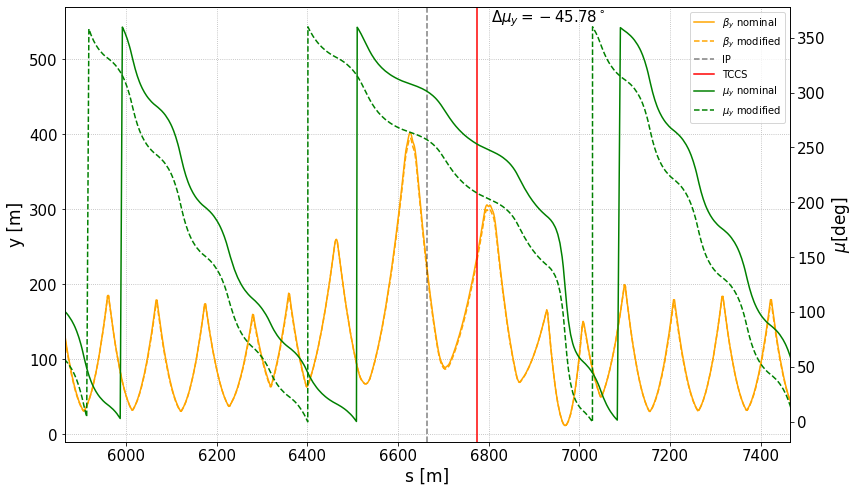

In [38]:
f3, a3 = compare_ip(df_tune, df_phase, IR3_s, N = 800, y_lim = 570, end_s=26658.883171485748, return_fig=True)
a3.text(6930, 550, r"$\Delta\mu_y=-45.78^\circ$", horizontalalignment='center', fontsize=15)
f3.savefig('./Plots/IR3_phase.png')

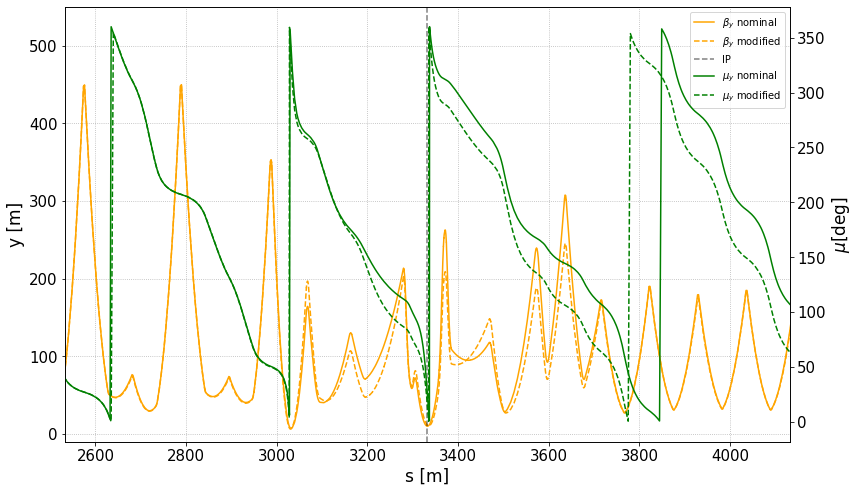

In [39]:
f2, a2 = compare_ip(df_tune, df_phase, IR2_s, N = 800, y_lim = 550, end_s=26658.883171485748, return_fig=True)
#f2.savefig('./Plots/IR2_phase.png')

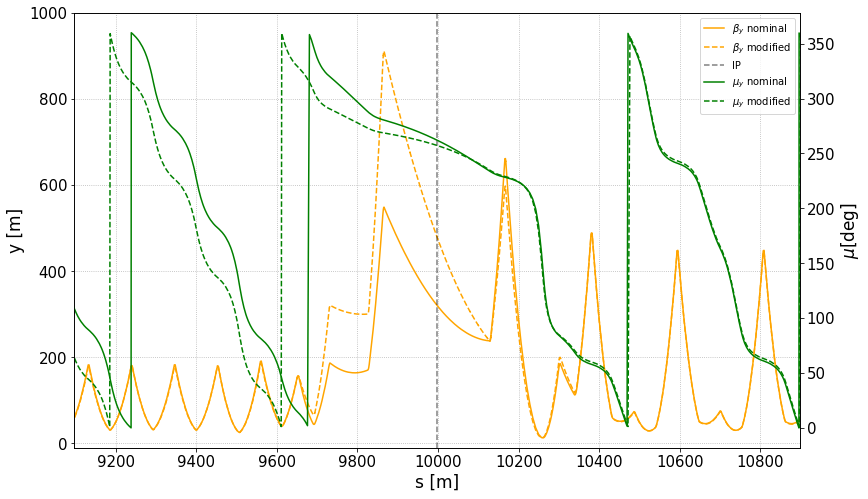

In [40]:
f4, a4 = compare_ip(df_tune, df_phase, IR4_s, N = 900, y_lim = 1000, end_s=26658.883171485748, return_fig=True)
#f4.savefig('./Plots/IR4_phase.png')

In [41]:
df = df_tune

In [42]:
def plot_ip_v1(df, IP_s,N = 1000, y_lim = 1300, end_s=26658.883171485748):
    TCCS_loc = end_s - 6773.7 #6775
    s_start = IP_s - N #19000#6300
    s_stop = IP_s + N #21000#7100
    fig, plot_axis = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
    pymadx.Plot._SetMachineAxesStyle(plot_axis[0])
    pymadx.Plot._DrawMachineLattice(plot_axis[0], layout_data_object)
    plot_axis[0].set_xlim(s_start,s_stop)
    plot_axis[1].plot(df["s"],df["bety"],color="orange")
    d_ax = plot_axis[1].twinx()
    d_ax.plot(df["s"], -df["dx"],color="green")

    #plot_axis[1].set_ylim(-10, 400)
    plot_axis[1].set_ylim(-10, y_lim)
    #plot_axis[1].set_ylim(-10, 400)

    plot_axis[1].set_xlabel('s [m]',  fontsize=17)
    plot_axis[1].set_xlim(s_start, s_stop)
    plot_axis[1].set_ylabel('y [m]',  fontsize=17)
    plot_axis[1].grid(linestyle=':')

    n=-10

    plot_axis[1].tick_params(axis='both', which='major', labelsize=15)
    #plot_axis[1].text(end_s - TCCS_loc, max(plot_axis[1].get_yticks())+n, "TCCS", horizontalalignment='center', fontsize=17)
    #plot_axis[1].text(end_s - TCCP_loc, max(plot_axis[1].get_yticks())+n, "TCCP", horizontalalignment='center', fontsize=17)
    #plot_axis[1].text(end_s - TCLA_loc, max(plot_axis[1].get_yticks())+n, "TCLA", horizontalalignment='center', fontsize=17)
    plot_axis[1].axvline(IP_s, color='r', linestyle='--')
    plot_axis[1].axvline(end_s - TCCS_loc, color='k', linestyle='--')

In [43]:
def plot_ip(df, IP_s, plot_axis, N = 800, y_lim = 1300, end_s=26658.883171485748, beta='bety'):
    TCCS_loc = end_s - 6773.7 #6775
    s_start = IP_s - N #19000#6300
    s_stop = IP_s + N #21000#7100

    pymadx.Plot._SetMachineAxesStyle(plot_axis[0])
    pymadx.Plot._DrawMachineLattice(plot_axis[0], layout_data_object)
    plot_axis[0].set_xlim(s_start,s_stop)
    plot_axis[1].plot(df["s"],df[beta],color="orange", label=r'$\beta_y$')
    d_ax = plot_axis[1].twinx()
    d_ax.plot(df["s"], -df["dx"],color="green", label=r'$D_x$')
    d_ax.set_ylabel(r'$D_x$',  fontsize=17)

    #plot_axis[1].set_ylim(-10, 400)
    plot_axis[1].set_ylim(-10, y_lim)
    #plot_axis[1].set_ylim(-10, 400)

    plot_axis[1].set_xlabel('s [m]',  fontsize=17)
    plot_axis[1].set_xlim(s_start, s_stop)
    plot_axis[1].set_ylabel('y [m]',  fontsize=17)
    plot_axis[1].grid(linestyle=':')

    n=-10

    plot_axis[1].tick_params(axis='both', which='major', labelsize=15)
    #plot_axis[1].text(end_s - TCCS_loc, max(plot_axis[1].get_yticks())+n, "TCCS", horizontalalignment='center', fontsize=17)
    #plot_axis[1].text(end_s - TCCP_loc, max(plot_axis[1].get_yticks())+n, "TCCP", horizontalalignment='center', fontsize=17)
    #plot_axis[1].text(end_s - TCLA_loc, max(plot_axis[1].get_yticks())+n, "TCLA", horizontalalignment='center', fontsize=17)
    plot_axis[1].axvline(IP_s, color='r', linestyle='--')
    plot_axis[1].axvline(end_s - TCCS_loc, color='k', linestyle='--')

    handles1, labels1 = plot_axis[1].get_legend_handles_labels()
    handles2, labels2 = d_ax.get_legend_handles_labels()

    # Merge the legends
    plot_axis[1].legend(handles1 + handles2, labels1 + labels2)

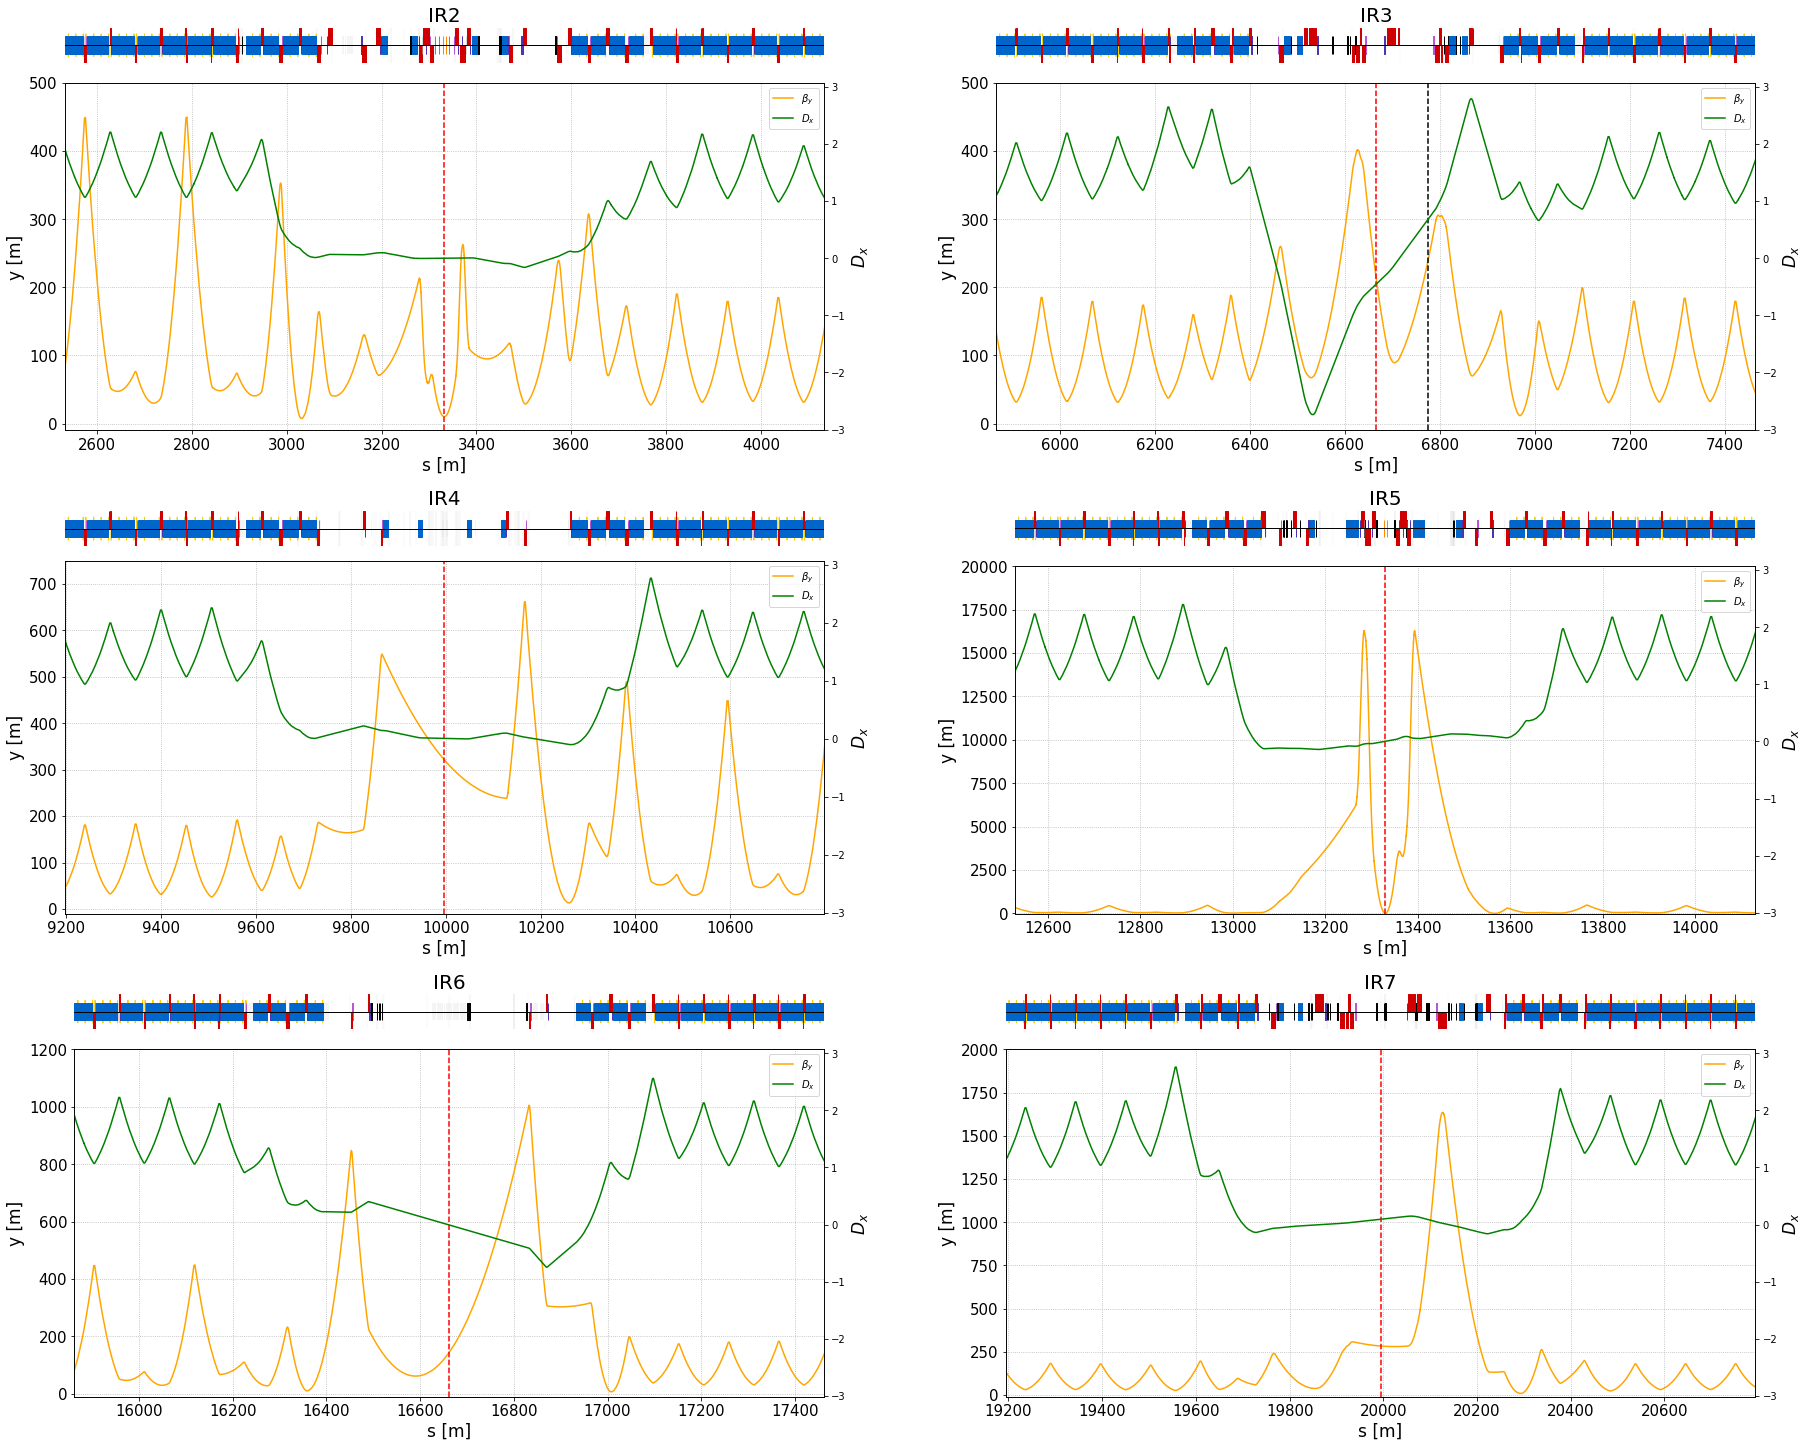

In [44]:
fig = plt.figure(layout='constrained', figsize=(25,20))
subfigs = fig.subfigures(3, 2, wspace=0.07)
IR2ax = subfigs[0][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
IR2ax[0].set_title('IR2', fontsize = 20)
plot_ip(df_tune, IR2_s, y_lim=500, plot_axis=IR2ax) 
IR3ax = subfigs[0][1].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
IR3ax[0].set_title('IR3', fontsize = 20)
plot_ip(df_tune, IR3_s, y_lim=500, plot_axis=IR3ax)  
IR4ax = subfigs[1][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
IR4ax[0].set_title('IR4', fontsize = 20)
plot_ip(df_tune, IR4_s, y_lim=750, plot_axis=IR4ax)
IR5ax = subfigs[1][1].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
IR5ax[0].set_title('IR5', fontsize = 20)
plot_ip(df_tune, IR5_s, y_lim=20000, plot_axis=IR5ax)
IR6ax = subfigs[2][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
IR6ax[0].set_title('IR6', fontsize = 20)
plot_ip(df_tune, IR6_s, y_lim=1200, plot_axis=IR6ax)
IR7ax = subfigs[2][1].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
IR7ax[0].set_title('IR7', fontsize = 20)
plot_ip(df_tune, IR7_s, y_lim=2000, plot_axis=IR7ax)

In [ ]:
#fig.savefig('./Plots/HL_IRs.png')

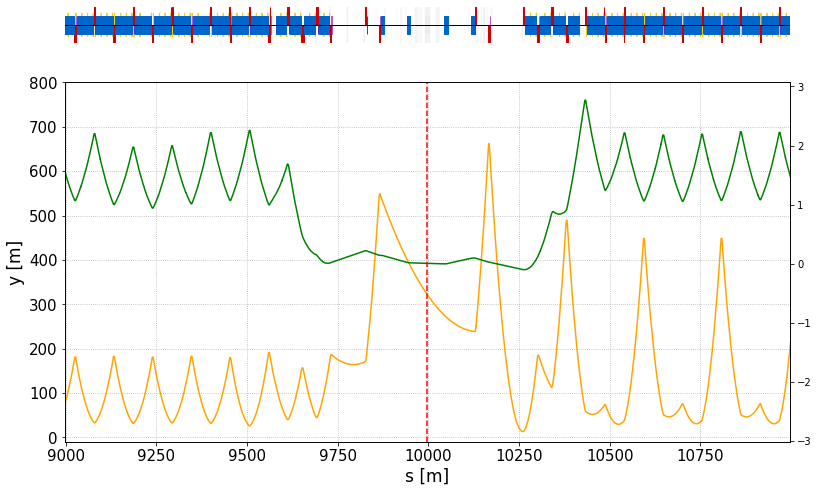

In [45]:
plot_ip_v1(df_tune, IR4_s, y_lim=800)    

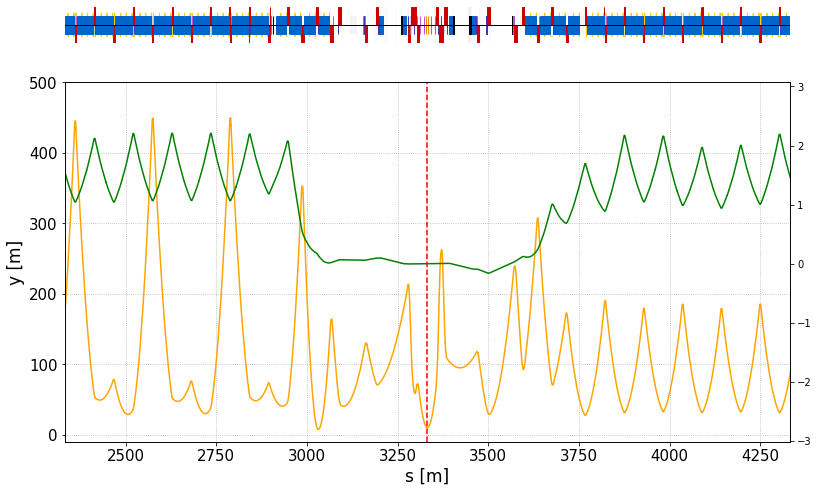

In [28]:
plot_ip_v1(df_tune, IR2_s, y_lim=500)    

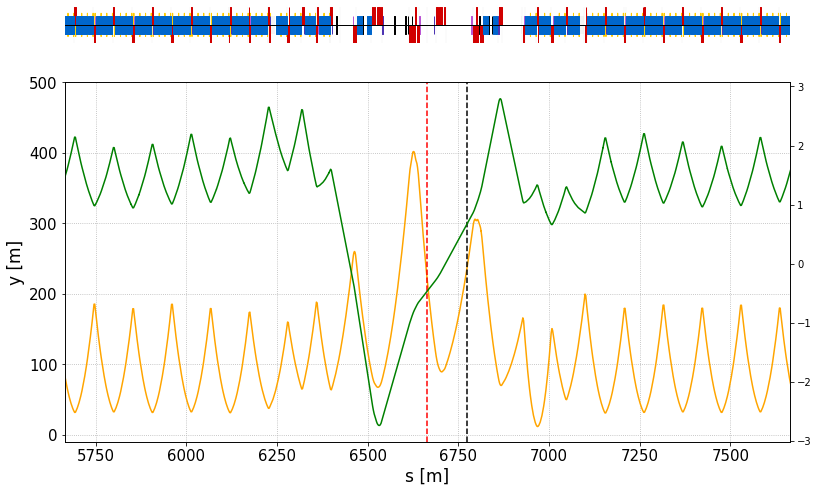

In [29]:
plot_ip_v1(df_tune, IR3_s, y_lim=500)    

In [30]:
plot_ip(df_tune, IR7_s, y_lim=2000)    

TypeError: plot_ip() missing 1 required positional argument: 'plot_axis'

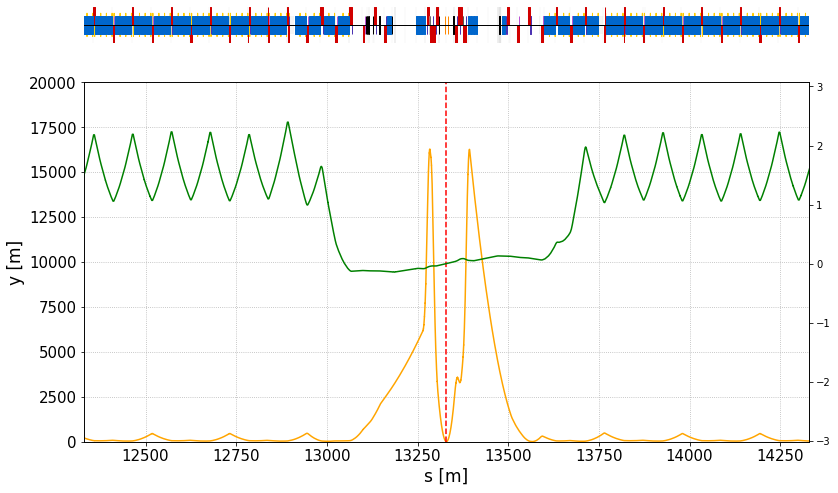

In [39]:
plot_ip_v1(IR5_s, y_lim=20000)    

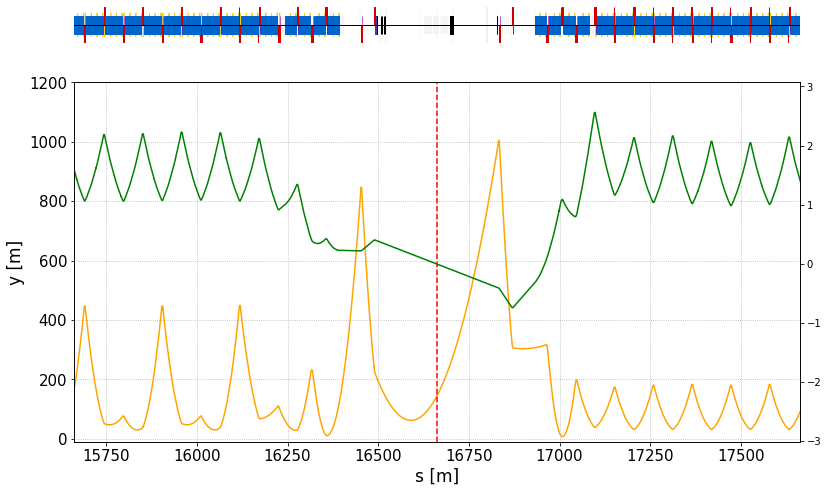

In [31]:
plot_ip_v1(df_tune, IR6_s, y_lim=1200)    

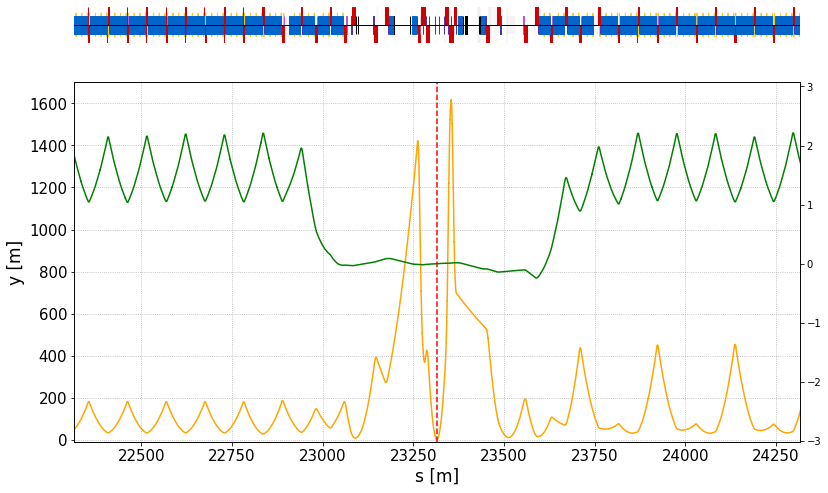

In [32]:
plot_ip_v1(df_tune, IR8_s, y_lim=1700)    

In [36]:
print('beta y TCP : ', twiss['bety', 'tcp.c6r7.b2'])
print('beta x TCP : ', twiss['betx', 'tcp.c6r7.b2'])

beta y TCP :  378.75519638489493
beta x TCP :  361.9341379977807


In [30]:
print('beta y TCCS : ', twiss['bety', TCCS_name])
print('beta y TCCP : ', twiss['bety', TCCP_name])
print('beta y TCLA : ', twiss['bety', TCLA_name])

beta y TCCS :  235.77369539159633
beta y TCCP :  281.7840594967735
beta y TCLA :  175.30833493680439


# Test phase advance

In [45]:
line_ref3 =  xt.Line.from_json("./input_files/HL_phase_scan/lines_ref/b4_sequence_noaper.json")
line_ref3.particle_ref = xp.Particles(mass0=0.9382720813e9, q0=1, p0c=7e12, x=0, y=0, zeta=0, delta=0)
tw_ref3 = line_ref3.twiss(method='4d')

Loading line from dict:   0%|          | 0/61371 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
print(tw_ref3.qx, tw_ref3.qy, tw_ref3.dqx, tw_ref3.dqy)
#xt.TargetSet(qx=62.313, qy=60.318, tol=1e-6, tag='tune'),
#xt.TargetSet(dqx=10.0, dqy=12.0, tol=0.01, tag='chrom'),

62.310004723884404 60.31999755060639 0.6182918906461055 1.2093387651646026


In [ ]:
line_ref3.vars['kqtf.b2']._get_value() 0.0011632196657614606,

0.0011632196657614606

In [66]:
line_ref3.vars.get_table()

AttributeError: module 'xdeps.refs' has no attribute 'CompactFormatter'

In [50]:
line_ph3 =  xt.Line.from_json("./input_files/HL_phase_scan/b4_sequence_patched_phadv_150.json")
tw_ph3 = line_ph3.twiss(method='4d')

Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           


In [51]:
print(tw_ph3.qx, tw_ph3.qy, tw_ph3.dqx, tw_ph3.dqy)

62.31299994730087 60.317999952441944 10.000001942245262 11.99999809884389


In [33]:
line_ref2 =  xt.Line.from_json("./input_files/Run3_phase_scan/lines_ref/flat_top_b2_noaper.json")
tw_ref2 = line_ref2.twiss()

Loading line from dict:   0%|          | 0/103397 [00:00<?, ?it/s]

Done loading line from dict.           


In [35]:
print(tw_ref2.qx, tw_ref2.qy, tw_ref2.dqx, tw_ref2.dqy)

62.28001640940227 60.310016028523386 9.992916804932861 10.001828229135867


In [39]:
line_ph2 =  xt.Line.from_json("./input_files/Run3_phase_scan/flat_top_b2_phadv_150.json")
tw_ph2 = line_ph2.twiss()

Loading line from dict:   0%|          | 0/175742 [00:00<?, ?it/s]

Done loading line from dict.           


In [41]:
print(tw_ph2.qx, tw_ph2.qy, tw_ph2.dqx, tw_ph2.dqy)

62.306687038924565 60.24360403969593 9.984192497469735 9.916140664216755


In [13]:
line_ref =  xt.Line.from_json("./MadX/2025_new/flat_top/track_flat_top_b2.json")
tw_ref = line_ref.twiss()

Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


In [14]:
print(tw_ref.qx, tw_ref.qy, tw_ref.dqx, tw_ref.dqy)
#qx0     = 62.28;   qy0     = 60.31;  dqx0    = 10.0; dqy0    = 10.0;

62.28001720730935 60.310016773779125 9.993188542622988 10.001634325931263


In [19]:
print(tw_ref['bety', 'ip1'], tw_ref['betx', 'ip1'])
print(tw_ref['bety', 'ip2'], tw_ref['betx', 'ip2'])
print(tw_ref['bety', 'ip3'], tw_ref['betx', 'ip3'])
print(tw_ref['bety', 'ip4'], tw_ref['betx', 'ip4'])
print(tw_ref['bety', 'ip5'], tw_ref['betx', 'ip5'])
print(tw_ref['bety', 'ip6'], tw_ref['betx', 'ip6'])
print(tw_ref['bety', 'ip7'], tw_ref['betx', 'ip7'])
print(tw_ref['bety', 'ip8'], tw_ref['betx', 'ip8'])

1.998655960097776 1.9932431184006634
10.038285085490086 10.03396774030437
217.93192585364415 121.44703640735189
303.25327831524766 231.4881524904832
1.9967465465610255 1.9959661964092275
168.06122958275256 153.74988622569919
149.10233856740476 121.5355709706173
2.002294935130539 2.013240577713861


In [ ]:
line_ref.vars['kqtf.b2']

vars['kqt13.l2b2']

In [ ]:
#line_ph =  xt.Line.from_json("./MadX/2025_new/flat_top/flat_top_b2_phadv_145_new_test.json")
line_ph =  xt.Line.from_json("./MadX/2025_new/flat_top/flat_top_b2_phadv_150_new.json")


Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


: 

In [78]:
print(tw_ph.qx, tw_ph.qy, tw_ph.dqx, tw_ph.dqy)
#qx0     = 62.28;   qy0     = 60.31;  dqx0    = 10.0; dqy0    = 10.0;

62.27994578376503 60.3096960825271 9.933405274509255 9.97064959953775


In [82]:
TCP_name = 'tcp.d6r7.b2'
TCCS_name = 'tccs.5r3.b2'

In [89]:
end_s = line_ph.get_length()

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'
TCP_name = 'tcp.d6r7.b2'

TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCP_loc_abs  = 6653.2543  #6653.3 #6655
PIX1_loc_abs = 6652.7039
PIX2_loc_abs = 6652.6929
PIX3_loc_abs = 6652.6819
TFT_loc_abs = 6652.114

TCCS_loc = end_s - TCCS_loc_abs #6773.7
TCCP_loc = end_s - TCCP_loc_abs #6653.3
TARGET_loc = end_s - (TCCP_loc_abs +  0.070/2 + 0.005/2)
TCLA_loc = line_ph.get_s_position()[line_ph.element_names.index(TCLA_name)]


line_ph.insert_element(at_s=TCCS_loc, element=xt.Marker(), name='tccs.5r3.b2')

tw_ph = line_ph.twiss()

print(f"Phase adv: { (float(tw_ph['muy', TCCS_name])% 1* 2*np.pi - float(tw_ph['muy', TCP_name])% 1* 2*np.pi)*180/np.pi}")

Slicing line:   0%|          | 0/102293 [00:00<?, ?it/s]

Phase adv: 173.8351936652643


In [ ]:
print(tw_ph['bety', 'ip1'], tw_ph['betx', 'ip1'])
print(tw_ph['bety', 'ip2'], tw_ph['betx', 'ip2'])
print(tw_ph['bety', 'ip3'], tw_ph['betx', 'ip3'])
print(tw_ph['bety', 'ip4'], tw_ph['betx', 'ip4'])
print(tw_ph['bety', 'ip5'], tw_ph['betx', 'ip5'])
print(tw_ph['bety', 'ip6'], tw_ph['betx', 'ip6'])
print(tw_ph['bety', 'ip7'], tw_ph['betx', 'ip7'])
print(tw_ph['bety', 'ip8'], tw_ph['betx', 'ip8'])

1.9986844327826934 1.9932276083463425
10.038343807686834 10.034050881904452
217.93418885665307 121.44609896000958
303.2517986479353 231.48899494647173
1.9967287236508793 1.9959640081845953
168.06249576725756 153.74949769398938
149.10245537787893 121.53647108576259
2.0022906853631444 2.0132615292436618


In [ ]:
line_ref.vars.info('kqtf')

#  vars['kqtf']._get_value()
   vars['kqtf'] = -0.029967929286812856

#  vars['kqtf']._expr is None

#  vars['kqtf']._find_dependant_targets()
   vars['dqx.b2_sq']
   vars['kqtd.a67b2']
   element_refs['mqt.14r6.b2..8'].knl[1]
   element_refs['mqt.14r6.b2..7'].knl[1]
   ... set _info(limit=None) to get all lines



In [ ]:
line_ref.vars['kqtf']._get_value() -0.029967929286812856,

-0.029967929286812856

In [76]:
line_ref.vars['kqtf']._find_dependant_targets()

[vars['kqtf'],
 vars['dqx.b2_sq'],
 vars['kqtd.a67b2'],
 element_refs['mqt.14r6.b2..8'].knl,
 element_refs['mqt.14r6.b2..8'],
 element_refs['mqt.14r6.b2..8'].knl[1],
 element_refs['mqt.14r6.b2..7'],
 element_refs['mqt.14r6.b2..7'].knl,
 element_refs['mqt.14r6.b2..7'].knl[1],
 element_refs['mqt.14r6.b2..6'],
 element_refs['mqt.14r6.b2..6'].knl,
 element_refs['mqt.14r6.b2..6'].knl[1],
 element_refs['mqt.14r6.b2..5'],
 element_refs['mqt.14r6.b2..5'].knl,
 element_refs['mqt.14r6.b2..5'].knl[1],
 element_refs['mqt.14r6.b2..4'].knl[1],
 element_refs['mqt.14r6.b2..4'],
 element_refs['mqt.14r6.b2..4'].knl,
 element_refs['mqt.14r6.b2..3'].knl[1],
 element_refs['mqt.14r6.b2..3'],
 element_refs['mqt.14r6.b2..3'].knl,
 element_refs['mqt.14r6.b2..2'],
 element_refs['mqt.14r6.b2..2'].knl[1],
 element_refs['mqt.14r6.b2..2'].knl,
 element_refs['mqt.14r6.b2..1'].knl,
 element_refs['mqt.14r6.b2..1'].knl[1],
 element_refs['mqt.14r6.b2..1'],
 element_refs['mqt.16r6.b2..8'],
 element_refs['mqt.16r6.b2..8']

In [90]:
line_ref_thick =  xt.Line.from_json("./MadX/2025_new/flat_top/track_flat_top_b2_no_aper_THICK.json")
tw_ref_thick = line_ref_thick.twiss()

Loading line from dict:   0%|          | 0/23179 [00:00<?, ?it/s]

Done loading line from dict.           


In [93]:
line_ref_thick.vars[ 'kq5.r2b2' ]._get_value()

0.00450537383873

In [10]:
line_true = xt.Line.from_json("./MadX/2025_new/flat_top/track_flat_top_b2.json")
TCCS_name = 'tccs.5r3.b2'
TCP_name = 'tcp.d6r7.b2'

end_s = line_true.get_length()
TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCS_loc = end_s - TCCS_loc_abs #6773.7

line_true.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)

Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


In [11]:
TCCS_name = 'tccs.5r3.b2'
TCP_name = 'tcp.d6r7.b2'

end_s = line_true.get_length()
TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCS_loc = end_s - TCCS_loc_abs #6773.7

line_true.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)

Slicing line:   0%|          | 0/102293 [00:00<?, ?it/s]

<Line  at 140104336929312>

In [ ]:
tw = line_true.twiss()

In [122]:
def getPhaseAdvance_muy_fractional(tw, start_name, end_name):
    return (tw['muy', end_name] - tw['muy', start_name]) % 1
def getPhaseAdvance(tw, start_name, end_name):
    return (tw['muy', end_name] - tw['muy', start_name])
def getPhaseAdvance_deg(tw, start_name, end_name):
    return (tw['muy', end_name] - tw['muy', start_name]) % 1 * 360

In [123]:
getPhaseAdvance_deg(tw, TCP_name, TCCS_name), getPhaseAdvance(tw, TCP_name, TCCS_name), getPhaseAdvance_muy_fractional(tw, TCP_name, TCCS_name)

(173.89263309033467, 29.483035091917596, 0.4830350919175963)

In [124]:
print(line_true['kqf.a23'], line_true['kqf.a34'])
print(line_true['kqf.a67'], line_true['kqf.a78'])

0.008740037422 0.008740037422
0.008772193705 0.008772193705


In [125]:
true_kqfa23 = line_true['kqf.a23']
true_kqfa34 = line_true['kqf.a34']
true_kqfa67 = line_true['kqf.a67']
true_kqda78 = line_true['kqf.a78']

In [126]:
print(tw['qx'], tw['qy'], tw['dqx'], tw['dqy'])

62.28001720728745 60.310016773773405 9.99318837905605 10.001634313780983


In [49]:
eps = -0.00

line_true['kqf.a23'] = true_kqfa23 + eps
line_true['kqf.a34'] = true_kqfa34 + eps
line_true['kqf.a67'] = true_kqfa67 - eps
line_true['kqf.a78'] = true_kqda78 - eps

In [62]:
tw = line_true.twiss()

In [127]:
tw_init = tw.get_twiss_init(TCP_name)

In [128]:
tw_init.betx

148.08046108686037

In [129]:
twsingle = line_true.twiss(start=TCP_name, end=TCCS_name, init=tw_init)

In [130]:
twsingle.rows[[TCCS_name,TCP_name]].cols['muy']

TwissTable: 2 rows, 2 cols
name                  muy
tccs.5r3.b2       44.7441
tcp.d6r7.b2       15.2611

In [131]:
((twsingle.rows[TCCS_name]['muy'][0]-twsingle.rows[TCP_name]['muy'][0])%1)*360

173.89263310675673

In [134]:
eps = 0.00032

#line_true['kqf.a23'] = true_kqfa23 + eps
line_true['kqf.a34'] = true_kqfa34 + eps
#line_true['kqf.a67'] = true_kqfa67 - eps
#line_true['kqf.a78'] = true_kqda78 - eps
twsingle_temp = line_true.twiss(start=TCP_name, end=TCCS_name, init=tw_init)
((twsingle_temp.rows[TCCS_name]['muy'][0]-twsingle_temp.rows[TCP_name]['muy'][0])%1)*360

150.5552414038182

In [135]:
tw2 = line_true.twiss()
getPhaseAdvance_deg(tw2, TCP_name, TCCS_name), getPhaseAdvance(tw2, TCP_name, TCCS_name), getPhaseAdvance_muy_fractional(tw2, TCP_name, TCCS_name)

(150.14800406052132, 29.417077789057004, 0.41707778905700366)

In [136]:
err  = 1
scale = 10
while np.abs(err) > 0.0001:
    line_true['kqf.a34'] = true_kqfa34 + eps
    tws = line_true.twiss(start=TCP_name, end=TCCS_name, init=tw_init)
    phaseadv = ((tws.rows[TCCS_name]['muy'][0]-tws.rows[TCP_name]['muy'][0])%1)*360
    print(phaseadv)
    err = 150-phaseadv
    if err < 0:
        eps += 0.000001*scale
    else:
        eps -= 0.000001*scale
    print(eps,err)
    scale *= 0.95

150.5552414038182
0.00033 -0.5552414038182008
149.8379052167725
0.0003205 0.16209478322750215
150.51935686326956
0.000329525 -0.5193568632695644
149.87196183354527
0.00032095125 0.1280381664547292
150.48697267115315
0.0003290963125 -0.4869726711531541
149.90269936985285
0.00032135850312500004 0.09730063014714574
150.45774724524406
0.00032870942203125006 -0.4577472452440645
149.93044116937668
0.0003217260490703126 0.06955883062332191
150.43137236301064
0.0003283602533832032 -0.4313723630106381
149.9554790991631
0.0003220577592859571 0.04452090083688631
150.4075698987448
0.0003280451286783409 -0.40756989874481064
149.97807660944275
0.0003223571277555763 0.021923390557248013
150.38608888071806
0.00032776072863220266 -0.3860888807180629
149.99847149683447
0.0003226273077994076 0.0015285031655309922
150.366702836849
0.0003275040575905629 -0.36670283684898664
150.01687839951174
0.0003321369698921604 -0.016878399511739417
149.6847091753098
0.00032773570320564276 0.31529082469020864
150.000266

In [98]:
eps1 = 0.00032760620446961456
eps2 = eps1

line_true['kqf.a23'] = true_kqfa23 - eps2
line_true['kqf.a34'] = true_kqfa34 + eps1
#line_true['kqf.a67'] = true_kqfa67 - eps
#line_true['kqf.a78'] = true_kqda78 - eps
twsingle_temp = line_true.twiss(start=TCP_name, end=TCCS_name, init=tw_init)
((twsingle_temp.rows[TCCS_name]['muy'][0]-twsingle_temp.rows[TCP_name]['muy'][0])%1)*360
twt = line_true.twiss()
twt.qx, twt.qy

(62.27366379043396, 60.31865820311419)

In [ ]:
62.28001720728745 60.310016773773405 9.99318837905605 10.001634313780983

In [167]:
eps1 = 0.0003249655884614848
eps2 = eps1*0.98055
eps3 = 0
eps4 = 0.0000001#*0.9805

line_true['kqf.a23'] = true_kqfa23 - eps2
line_true['kqf.a34'] = true_kqfa34 + eps1
line_true['kqf.a67'] = true_kqfa67 - eps3
line_true['kqf.a78'] = true_kqda78 - eps4
twsingle_temp = line_true.twiss(start=TCP_name, end=TCCS_name, init=tw_init)
print(((twsingle_temp.rows[TCCS_name]['muy'][0]-twsingle_temp.rows[TCP_name]['muy'][0])%1)*360)
twt = line_true.twiss()
twt.qx, twt.qy

150.19894855565255


(62.28078892424896, 60.31717157818489)

In [32]:
print(line_true['kqf.a23'], line_true['kqf.a34'])
print(line_true['kqf.a67'], line_true['kqf.a78'])

0.007740037422 0.007740037422
0.009772193705000001 0.009772193705000001


In [33]:
tw2 = line_true.twiss()
print(tw2['qx'], tw2['qy'], tw2['dqx'], tw2['dqy'])

62.261279726521444 60.32629026811234 11.853897400797564 11.821228197774758


In [34]:
getPhaseAdvance_deg(tw2, TCP_name, TCCS_name), getPhaseAdvance(tw2, TCP_name, TCCS_name), getPhaseAdvance_muy_fractional(tw2, TCP_name, TCCS_name)

(166.01505713092934, 29.461152936474804, 0.4611529364748037)

In [68]:
df2 = get_twiss_df(tw2)
df2

,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,2.143735,2.021545,0.065111,-0.024669,62.280734,60.308180,0.001025,0.008684
ip2,9.323847,9.809322,-0.061212,-0.017334,54.535302,52.206143,0.036632,-0.000082
ip3,128.174426,219.916432,2.474560,-2.669229,46.316381,44.895561,0.359565,0.010425
ip4,235.025885,308.344217,0.441207,-0.487749,38.767203,38.045460,0.186400,-0.000852
ip5,1.865000,2.002152,0.006013,0.024827,31.115289,30.590283,-0.021435,-0.003463
ip6,145.099775,166.688365,-0.493111,0.662964,23.576202,22.825740,0.233347,0.001881
ip7,115.850954,151.832199,1.273435,-1.396536,16.084355,15.575895,-0.150829,0.000967
ip8,1.825744,1.943840,-0.012839,-0.001279,8.206274,7.851498,0.003078,0.001966
s.ds.l4.b2,33.861848,169.312031,-0.521417,2.303607,39.912809,38.687321,-1.031104,-0.014759


In [69]:
diff = df1 - df2
diff

,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,-0.150491,-0.022889,-0.069217,0.027660,-0.000717,0.001837,-0.005163,0.001460
ip2,0.710121,0.228963,0.064190,0.018657,-0.011322,0.002528,0.006132,0.001177
ip3,-6.727390,-1.984506,-0.183302,0.036858,0.110579,-0.019731,0.182340,-0.002554
ip4,-3.537733,-5.090939,0.059232,-0.012933,0.211561,-0.037120,-0.367080,0.000774
ip5,0.130966,-0.005405,-0.005048,-0.026822,0.217262,-0.036672,0.020354,0.013690
ip6,8.650112,1.372865,-0.066250,0.031214,0.219689,-0.040845,-0.119133,-0.002218
ip7,5.684617,-2.729860,0.012763,0.013095,0.107582,-0.016777,0.026969,0.001081
ip8,0.187497,0.058455,0.014590,0.003243,-0.006533,0.001933,0.001179,0.002903
s.ds.l4.b2,-0.196944,2.302541,-0.017754,0.019944,0.214109,-0.037052,-0.121933,0.000482


In [20]:
line_test = xt.Line.from_json("./MadX/2025_new/flat_top/forSimon/flat_top_b2_phadv_150_new_test_nice.json")
TCCS_name = 'tccs.5r3.b2'
TCP_name = 'tcp.d6r7.b2'

end_s = line_test.get_length()
TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCS_loc = end_s - TCCS_loc_abs #6773.7

line_test.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)

Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102293 [00:00<?, ?it/s]

<Line  at 140103792051440>

In [33]:
line_test2= xt.Line.from_json("./MadX/2025_new/flat_top/forSimon/flat_top_b2_phadv_200_new_test_nice2.json")
TCCS_name = 'tccs.5r3.b2'
TCP_name = 'tcp.d6r7.b2'

end_s = line_test2.get_length()
TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCS_loc = end_s - TCCS_loc_abs #6773.7

line_test2.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)

Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102293 [00:00<?, ?it/s]

<Line  at 140104514549504>

In [34]:
tw_test2 = line_test2.twiss()

In [ ]:
tw_test = line_test2.twiss()

In [ ]:
line_true = xt.Line.from_json("./MadX/2025_new/flat_top/track_flat_top_b2.json")
TCCS_name = 'tccs.5r3.b2'
TCP_name = 'tcp.d6r7.b2'

end_s = line_true.get_length()
TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCS_loc = end_s - TCCS_loc_abs #6773.7

line_true.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)

In [12]:
tw = line_true.twiss()


In [17]:
def get_twiss_df(tw, end_name = TCCS_name, start_name = TCP_name):
    
    print("Phase adv: ", (tw['muy', end_name] - tw['muy', start_name]) % 1 * 360)
    print(f"Tune: {tw['qx']}, {tw['qy']}")
    print(f"Chrom: {tw['dqx']}, {tw['dqy']}")

    return tw.rows[['ip1','ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8', 's.ds.l4.b2', 's.ds.l2.b2']].cols[['betx', 'bety', 'alfx', 'alfy', 'mux', 'muy', 'dx','dpx']].to_pandas().set_index('name')

In [18]:
df1 = get_twiss_df(tw)
df1

Phase adv:  173.89263309033467
Tune: 62.28001720728745, 60.310016773773405
Chrom: 9.99318837905605, 10.001634313780983


,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,1.993243,1.998656,-0.004106,0.002991,62.280017,60.310017,-0.004138,0.010144
ip2,10.033968,10.038285,0.002978,0.001323,54.523980,52.208671,0.042764,0.001095
ip3,121.447036,217.931926,2.291258,-2.632371,46.426960,44.875830,0.541905,0.007871
ip4,231.488152,303.253278,0.500439,-0.500682,38.978765,38.008340,-0.180681,-0.000078
ip5,1.995966,1.996747,0.000964,-0.001996,31.332551,30.553611,-0.001082,0.010227
ip6,153.749886,168.061230,-0.559361,0.694178,23.795891,22.784895,0.114214,-0.000337
ip7,121.535571,149.102339,1.286199,-1.383441,16.191938,15.559118,-0.123860,0.002047
ip8,2.013241,2.002295,0.001751,0.001964,8.199741,7.853431,0.004258,0.004869
s.ds.l4.b2,33.664903,171.614572,-0.539171,2.323551,40.126918,38.650269,-1.153036,-0.014277


In [22]:
df2 = get_twiss_df(tw_test)
df2

Phase adv:  150.00803128634487
Tune: 62.28001711252835, 60.310016935286455
Chrom: 9.999274424643545, 9.999151072932477


,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,2.126376,1.991366,0.004334,-0.003959,62.280017,60.310017,-0.003963,0.004086
ip2,9.401700,9.961201,-0.001002,0.002806,54.524962,52.207999,0.015703,0.000961
ip3,114.561335,220.685637,2.183191,-2.668005,46.481113,44.864455,0.538546,0.007606
ip4,226.920781,305.642189,0.600626,-0.470347,38.768035,38.041248,0.374111,-0.002538
ip5,2.234339,1.973319,-0.002729,0.030822,31.130944,30.586611,-0.053880,-0.002023
ip6,170.039421,168.897831,-0.672293,0.662865,23.598053,22.823279,0.516273,0.003175
ip7,111.982981,144.760570,1.138251,-1.303045,15.908342,15.607651,-0.060695,-0.003183
ip8,1.902097,1.990928,0.032803,0.007360,8.197863,7.852447,-0.007217,0.002924
s.ds.l4.b2,27.403104,169.878012,-0.545133,2.299247,39.944301,38.683974,-1.036311,-0.017547


In [23]:
diff = df1 - df2
diff

,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,-0.133133,0.007290,-0.008440,0.006950,9.475910e-08,-1.615131e-07,-0.000175,0.006058
ip2,0.632267,0.077084,0.003979,-0.001483,-9.823256e-04,6.718545e-04,0.027061,0.000134
ip3,6.885702,-2.753712,0.108067,0.035634,-5.415229e-02,1.137546e-02,0.003359,0.000265
ip4,4.567371,-2.388911,-0.100186,-0.030335,2.107294e-01,-3.290811e-02,-0.554791,0.002460
ip5,-0.238372,0.023428,0.003694,-0.032817,2.016068e-01,-3.300018e-02,0.052798,0.012250
ip6,-16.289535,-0.836601,0.112932,0.031313,1.978378e-01,-3.838461e-02,-0.402059,-0.003513
ip7,9.552590,4.341768,0.147947,-0.080396,2.835956e-01,-4.853296e-02,-0.063165,0.005230
ip8,0.111143,0.011367,-0.031052,-0.005396,1.878188e-03,9.839582e-04,0.011474,0.001945
s.ds.l4.b2,6.261799,1.736559,0.005962,0.024303,1.826176e-01,-3.370533e-02,-0.116725,0.003270


In [35]:
df3 = get_twiss_df(tw_test2)
df3

Phase adv:  200.00190697316683
Tune: 62.28000000732048, 60.31000001060074
Chrom: 9.999566763667644, 10.000042539743959


,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,2.008008,1.996561,-0.005236,-0.024137,62.280000,60.310000,0.014967,0.009763
ip2,9.961250,9.777475,0.004612,-0.005301,54.523743,52.207026,0.042511,-0.003181
ip3,115.425207,214.828368,2.080929,-2.621150,46.202927,44.921648,0.283378,0.010860
ip4,241.667773,302.536773,0.527661,-0.532360,38.986412,38.009983,0.067315,-0.000871
ip5,1.985253,2.028289,-0.041930,-0.031279,31.344025,30.554946,-0.019451,0.002747
ip6,150.094253,166.805394,-0.581676,0.720993,23.806812,22.781364,0.241221,0.001195
ip7,122.064718,152.217220,1.278719,-1.459821,16.330832,15.536654,-0.158304,0.001983
ip8,2.002614,1.951462,0.006987,0.010542,8.199235,7.850576,0.009422,-0.004331
s.ds.l4.b2,37.451990,173.254137,-0.538018,2.351468,40.120650,38.650691,-1.199581,-0.019675


In [36]:
df1-df3

,betx,bety,alfx,alfy,mux,muy,dx,dpx
name,,,,,,,,
ip1,-0.014765,0.002095,0.001131,0.027128,0.000017,0.000017,-0.019105,0.000381
ip2,0.072717,0.260810,-0.001635,0.006624,0.000237,0.001645,0.000252,0.004276
ip3,6.021829,3.103558,0.210329,-0.011221,0.224033,-0.045818,0.258527,-0.002989
ip4,-10.179621,0.716505,-0.027222,0.031678,-0.007647,-0.001643,-0.247995,0.000793
ip5,0.010713,-0.031542,0.042894,0.029284,-0.011475,-0.001335,0.018369,0.007480
ip6,3.655633,1.255835,0.022315,-0.026815,-0.010921,0.003531,-0.127007,-0.001532
ip7,-0.529147,-3.114882,0.007480,0.076380,-0.138895,0.022464,0.034444,0.000064
ip8,0.010626,0.050833,-0.005236,-0.008578,0.000506,0.002855,-0.005164,0.009200
s.ds.l4.b2,-3.787087,-1.639565,-0.001153,-0.027918,0.006268,-0.000422,0.046545,0.005398


In [125]:
    def doMatch(opt):
        opt.solve()
        matchSummary(opt)
        opt.log().rows[-5:]  

    def matchSummary(opt):
        for tt in opt._err.targets:
            if tt.line:
                nn=" ".join((tt.line,)+tt.tar)
                rr=tt.action.run()[tt.line][tt.tar]
            else:
                nn=tt.tar
                if(callable(nn)):
                    temptw = lhc.twiss()
                    rr = nn(temptw)
                    del temptw  
                    string = nn.__repr__()
                    str1 = string.split('(')[1]
                    str2 = string.split('(')[2].split(')')[0]
                    nn = [str1,str2]
                else:
                    rr=tt.action.run()[tt.tar]
                nn=": ".join(nn)
            if(type(tt.value)==xt.match.LessThan):
                vv=tt.value.upper
                dd=(rr-vv)
                print(f'{nn:25}: {rr:15.7e} {vv:15.7e} d={dd:15.7e} {rr<(vv+tt.tol)}') 
            elif(type(tt.value)==xt.match.GreaterThan):
                vv=tt.value.lower
                dd=(rr-vv)
                print(f'{nn:25}: {rr:15.7e} {vv:15.7e} d={dd:15.7e} {rr>(vv-tt.tol)}')
            elif(hasattr(tt,'rhs')):
                vv=tt.rhs
                dd=(rr-vv)
                if(tt.ineq_sign=='>'):
                    print(f'{nn:25}: {rr:15.7e} {vv:15.7e} d={dd:15.7e} {rr>(vv-tt.tol)}')
                else:
                    print(f'{nn:25}: {rr:15.7e} {vv:15.7e} d={dd:15.7e} {rr<(vv+tt.tol)}')   
            else:
                vv=tt.value
                dd=(rr-vv)
                dd=np.abs(dd)
                print(f'{nn:25}: {rr:15.7e} {vv:15.7e} d={dd:15.7e} {dd<tt.tol}') 


In [130]:
    optphase_deg  = 150 #float(sys.argv[1])
    deg_name = round(optphase_deg)
    optphase = optphase_deg/360

    phaseTCP_IP2 = getPhaseAdvance(tw, TCP_name, 'ip2')
    phaseTCP_cry0 = getPhaseAdvance(tw, TCP_name, TCCS_name)
    phaseCryIP20 = getPhaseAdvance(tw, TCCS_name, 'ip2')

    print(f"\nPhase TCP to Cry:     {phaseTCP_cry0}, Phase Cry to IP2:     {phaseCryIP20}, sum: {phaseTCP_cry0 + phaseCryIP20}, Phase TCP to IP2: {phaseTCP_IP2},  ")

    new_tcp_cry_phase = int(phaseTCP_cry0) + optphase
    new_cry_ip2_phase =    phaseTCP_IP2 - new_tcp_cry_phase


Phase TCP to Cry:     29.483035091917596, Phase Cry to IP2:     7.464585622389734, sum: 36.947620714307334, Phase TCP to IP2: 36.947620714307334,  


In [132]:
opt2 = line_true.match(solve=False,
                default_tol={None: 5e-8},  #{None: 5e-8}
                solver_options={"max_rel_penalty_increase": 2.}, 
                #method='4d',
                vary=[
                    xt.VaryList(['kqtf', 'kqtd'], step=1e-8, tag='quad'),                      
                    xt.VaryList(['ksf', 'ksd'], step=1e-4,  tag='sext'),      #limits=[-0.1, 0.1],
                    #xt.VaryList(['kqf.a23', 'kqf.a34', 'kqf.a67', 'kqf.a78'], step=1e-8, tag='x'),
                ],
                targets = [
                    xt.TargetSet(qx=62.28, qy=60.31, tol=1e-6, tag='tune'),                         
                    xt.TargetSet(dqx=10.0, dqy=10.0, tol=0.01, tag='chrom'),     
                    #xt.TargetRelPhaseAdvance('muy', new_tcp_cry_phase, tol=1e-3, end = TCCS_name, start = TCP_name, tag='ph_tcp_cry'),                      
                ]                                             
)
opt2.assert_within_tol=False



print('Matching tune and chroma.....')
doMatch(opt2)




: 

In [127]:
tw3 = line_true.twiss()

In [128]:
print(tw3.qx, tw3.qy, tw3.dqx, tw3.dqy)

62.280000010690756 60.30999999080228 9.999422808633085 9.999652208989573


# Inverted polarity 

In [7]:
line_injection_2024 = xt.Line.from_json("./MadX/2024/track_injection_b2.json")

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


In [9]:
tw = line_injection_2024.twiss()
print(tw.qx, tw.qy, tw.dqx, tw.dqy)

62.27995365393352 60.30995346319294 9.992124925588541 9.999400081994736


In [10]:
line_injection_2025_new = xt.Line.from_json("./MadX/2025_new/injection/no_twocryst/track_injection_b2.json")

Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
tw = line_injection_2025_new.twiss()
print(tw.qx, tw.qy, tw.dqx, tw.dqy)



62.27995778379605 60.30995763470261 9.992188193024276 9.99928185358101


In [23]:
tw2025 = line_injection_2025.twiss()

In [22]:
line_injection_2025 = xt.Line.from_json("./MadX/2025/injection/track_injection_b2.json")

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


In [27]:
tw2024 = line_injection_2024.twiss()
tw2025 = line_injection_2025.twiss()


In [ ]:
def get_emittance(line, emittance_n):
    energy = line.particle_ref.p0c[0]
    beta_rel = line.particle_ref.beta0[0]
    gamma = line.particle_ref.gamma0[0]
    emittance = emittance_n/(beta_rel*gamma)
    return emittance

In [ ]:
emitt = get_emittance(line_injection_2025_new, 2.5e-6)
n_env = 5

array([0.00119734, 0.00119734, 0.00119734, ..., 0.00119734, 0.00119734,
       0.00119734])

/tmp/cmaccani/ipykernel_71931/843613077.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


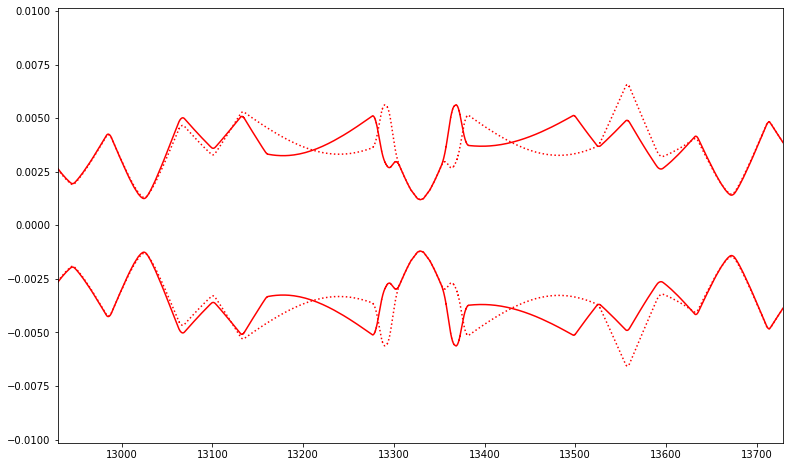

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13,8))
ax.plot(tw2024['s'], n_env*np.sqrt(emitt*tw2024['bety']), color='red')
ax.plot(tw2025['s'], n_env*np.sqrt(emitt*tw2025['bety']), color='red', linestyle = ':')
ax.plot(tw2024['s'], -n_env*np.sqrt(emitt*tw2024['bety']), color='red')
ax.plot(tw2025['s'], -n_env*np.sqrt(emitt*tw2025['bety']), color='red', linestyle = ':')
ax.set_xlim(tw2024.rows['ip5'].s[0]-400, tw2024.rows['ip5'].s[0]+400)



(26258.88317064787, 26658.88317064787)

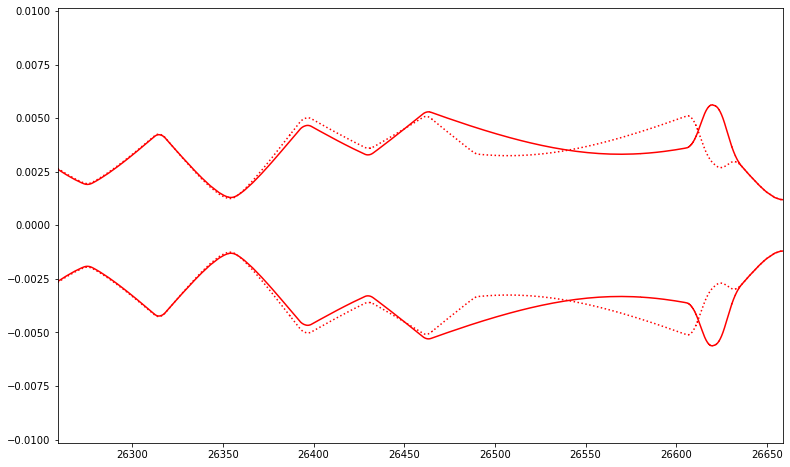

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(13,8))
ax.plot(tw2024['s'], n_env*np.sqrt(emitt*tw2024['bety']), color='red')
ax.plot(tw2025['s'], n_env*np.sqrt(emitt*tw2025['bety']), color='red', linestyle = ':')
ax.plot(tw2024['s'], -n_env*np.sqrt(emitt*tw2024['bety']), color='red')
ax.plot(tw2025['s'], -n_env*np.sqrt(emitt*tw2025['bety']), color='red', linestyle = ':')
ax.set_xlim(tw2024.rows['ip1'].s[0]-400, tw2024.rows['ip1'].s[0])


/tmp/cmaccani/ipykernel_71931/2018973624.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


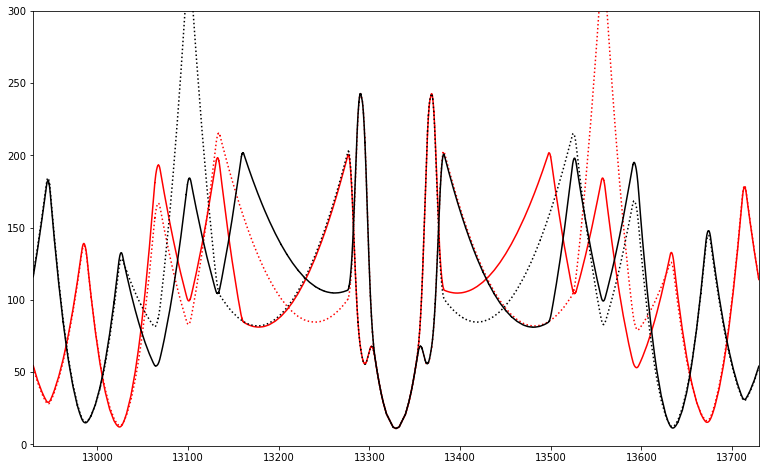

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(13,8))
ax.plot(tw2024['s'], tw2024['bety'], color='red')
ax.plot(tw2025['s'], tw2025['bety'], color='red', linestyle = ':')
ax.plot(tw2024['s'], tw2024['betx'], color='black')
ax.plot(tw2025['s'], tw2025['betx'], color='black', linestyle = ':')
ax.set_xlim(tw2024.rows['ip5'].s[0]-400, tw2024.rows['ip5'].s[0]+400)
ax.set_ylim(-1,300)
fig.show()



In [21]:
print(line_injection_2024.element_dict['MQXA.1L5..1'.lower()])
print(line_injection_2025_new.element_dict['MQXA.1L5..1'.lower()])

Multipole(_order=1, inv_factorial_order=1, length=0.0498, hxl=0, radiation_flag=0, delta_taper=0, knl=array([0.        , 0.00042528]), ksl=array([0., 0.]), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))
Multipole(_order=1, inv_factorial_order=1, length=0.0498, hxl=0, radiation_flag=0, delta_taper=0, knl=array([ 0.        , -0.00042897]), ksl=array([0., 0.]), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _internal_record_id=RecordIdentifier(buffer_id=0, offset=0))


In [55]:
line_injection_2024 = xt.Line.from_json("./MadX/2024/track_injection_b2.json")
line_injection_2025 = xt.Line.from_json("./MadX/2025/injection/track_injection_b2.json")
line_injection_2025_new = xt.Line.from_json("./MadX/2025_new/injection/no_twocryst/track_injection_b2.json")

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


In [47]:
line_flat_top_2024 = xt.Line.from_json("./MadX/2024/track_flat_top_b2.json")
line_flat_top_2025 = xt.Line.from_json("./MadX/2025/flat_top/track_flat_top_b2.json")
line_flat_top_2025_new = xt.Line.from_json("./MadX/2025_new//flat_top/track_flat_top_b2.json")

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


# GR

In [17]:
HL_rem_IR7_tune = './input_files/HL_IR7_tune_changed/b4_sequence_patched_tune.json'
coll_file_HL_orig = "./input_files/colldbs/HL_tight.yaml"

In [18]:
tw, df_ap, line_HL_o = load_line(HL_rem_IR7_tune, coll_file_HL_orig)
df_tw= tw.to_pandas()
df_tw = change_coordinates_to_b1(df_tw, line_HL_o.get_length())
df_tw = filter_aperture_rotations(df_tw, line_HL_o)


Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


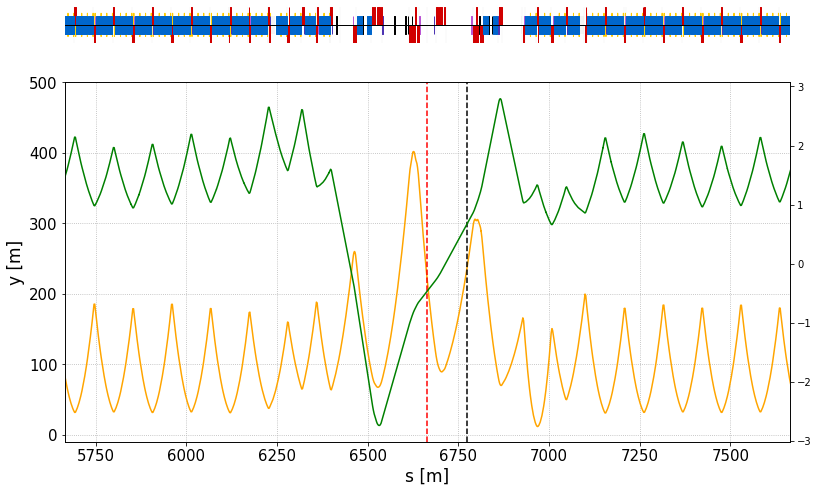

In [19]:
plot_ip_v1(df_tw, IR3_s, y_lim=500)

In [20]:
df_tw.query('name=="ip3"').index

Int64Index([113045], dtype='int64')

In [21]:
d = df_tw.iloc[df_tw.query('name=="mq.7r3.b2"').index[0] :df_tw.query('name=="mqtli.7l3.b2"').index[0]-100]
d['name']

110413       bpm_a.7r3.b2_aper
110414            bpm_a.7r3.b2
110415       bpm_a.7r3.b2_exit
110416             drift_20651
110417    bpm_a.7r3.a.b2_entry
                  ...         
115773          vmaab.7l3.a.b2
115774     vmaab.7l3.a.b2_exit
115775    vcddn.7l3.b.b2_entry
115776     vcddn.7l3.b.b2_aper
115777          vcddn.7l3.b.b2
Name: name, Length: 5365, dtype: object

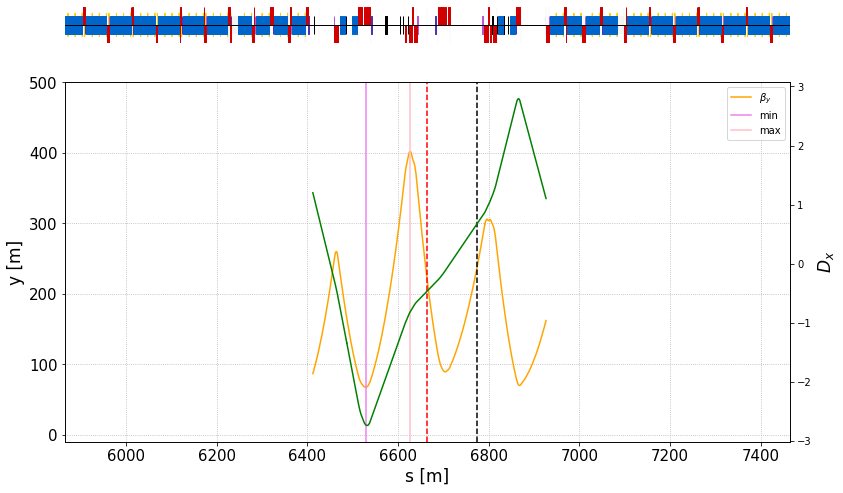

In [22]:
df = d
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
plot_ip(df_tw, IR3_s, ax,y_lim=500)
ax[1].axvline(d.iloc[np.where(d['bety']==min(d['bety']))[0]]['s'].iloc[0], color='violet', linestyle='-', label='min')
ax[1].axvline(d.iloc[np.where(d['bety']==max(d['bety']))[0]]['s'].iloc[0], color='pink', linestyle='-', label='max')
ax[1].legend()

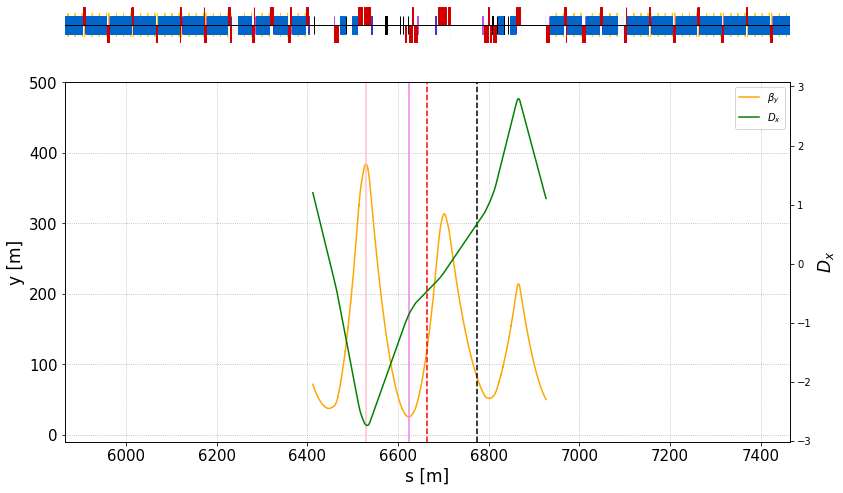

In [23]:
df = d
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
plot_ip(df_tw, IR3_s, ax,y_lim=500, beta='betx')
ax[1].axvline(d.iloc[np.where(d['betx']==min(d['betx']))[0]]['s'].iloc[0], color='violet', linestyle='-', label='min')
ax[1].axvline(d.iloc[np.where(d['betx']==max(d['betx']))[0]]['s'].iloc[0], color='pink', linestyle='-', label='max')

In [24]:
print('max y: ', d.iloc[np.where(d['bety']==max(d['bety']))[0]]['s'].iloc[0], d.iloc[np.where(d['bety']==max(d['bety']))[0]]['name'].to_list())
print('min y: ', d.iloc[np.where(d['bety']==min(d['bety']))[0]]['s'].iloc[0], d.iloc[np.where(d['bety']==min(d['bety']))[0]]['name'].to_list())
print('max x: ', d.iloc[np.where(d['betx']==max(d['betx']))[0]]['s'].iloc[0],  d.iloc[np.where(d['betx']==max(d['betx']))[0]]['name'].to_list())
print('min x: ', d.iloc[np.where(d['betx']==min(d['betx']))[0]]['s'].iloc[0],  d.iloc[np.where(d['betx']==min(d['betx']))[0]]['name'].to_list())

max y:  6626.128995520019 ['mqwa.d4l3.b2..1_exit', 'drift_21048']
min y:  6528.569595520017 ['mqwb.5l3.b2..4_entry', 'mqwb.5l3.b2..4_aper', 'mqwb.5l3.b2..4', 'mqwb.5l3.b2..4_exit', 'drift_21177']
max x:  6529.3983955200165 ['mqwb.5l3.b2..3_entry', 'mqwb.5l3.b2..3_aper', 'mqwb.5l3.b2..3', 'mqwb.5l3.b2..3_exit', 'drift_21176']
min x:  6624.471395520017 ['mqwa.d4l3.b2..3_entry', 'mqwa.d4l3.b2..3_aper', 'mqwa.d4l3.b2..3', 'mqwa.d4l3.b2..3_exit', 'drift_21051']


In [25]:
print(df_tw[['mux', 'muy']].iloc[-1])

mux    62.313
muy    60.318
Name: 151133, dtype: float64


In [26]:
df_tw_B1.query('name=="tclpx.4l1.b2_upstream_aper"')

NameError: name 'df_tw_B1' is not defined

In [ ]:
df_tw.iloc[ df_tw.query('name=="tclpx.4l1.b2"').index[0]-5: df_tw.query('name=="tclpx.4l1.b2"').index[0] +5]

,name,s,x,px,y,py,zeta,delta,ptau,W_matrix,...,bx_chrom,by_chrom,ax_chrom,ay_chrom,wx_chrom,wy_chrom,ddx,ddpx,ddy,ddpy
1242,drift_231,26523.769171,-0.002220,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[71.25494004338073, -5.551115123125783e-16, 0...",...,64.263899,-58.583690,-465.142773,-535.087064,469.561122,538.284511,-369.200342,4.035726,-127.212224,0.687129
1243,tclpx.4l1.b2_entry,26523.269171,-0.002130,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1244,tclpx.4l1.b2_aper_offset_entry,26523.269171,-0.002130,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1245,tclpx.4l1.b2_aper,26523.269171,-0.002142,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1246,tclpx.4l1.b2_aper_offset_exit,26523.269171,-0.002142,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1247,tclpx.4l1.b2,26523.269171,-0.002130,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1248,tclpx.4l1.b2_exit,26523.269171,-0.002130,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1249,drift_232,26523.269171,-0.002130,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.86737502958654, 1.6653345369377348e-15, 0...",...,64.366948,-58.425779,-465.430344,-535.142144,469.860095,538.322102,-367.182966,4.035726,-126.867651,0.687129
1250,tclpx.4l1.b2_mkex_entry,26522.769171,-0.002039,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.47981071823989, 2.6645352591003757e-15, 0...",...,64.471128,-58.267119,-465.717753,-535.197256,470.159070,538.359694,-365.165589,4.035726,-126.523078,0.687129
1251,tclpx.4l1.b2_mkex_aper_offset_entry,26522.769171,-0.002039,0.000181,-0.000001,6.699848e-09,0.000015,0.0,0.0,"[[70.47981071823989, 2.6645352591003757e-15, 0...",...,64.471128,-58.267119,-465.717753,-535.197256,470.159070,538.359694,-365.165589,4.035726,-126.523078,0.687129


## B1

In [ ]:
# qx=62.313, qy=60.318

In [27]:
HL_rem_IR7_B1 = './input_files/HL_IR7_tune_changed/b1_sequence_tune.json'
coll_file_HL_orig = "./input_files/colldbs/HL_tight.yaml"

In [28]:
tw_B1, df_ap, line_HL_o_B1 = load_line(HL_rem_IR7_B1, coll_file_HL_orig, B='B1')
df_tw_B1= tw_B1.to_pandas()

Loading line from dict:   0%|          | 0/149289 [00:00<?, ?it/s]

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [29]:
df_tw_B1[['mux', 'muy']].iloc[-1]

mux    62.313
muy    60.318
Name: 149298, dtype: float64

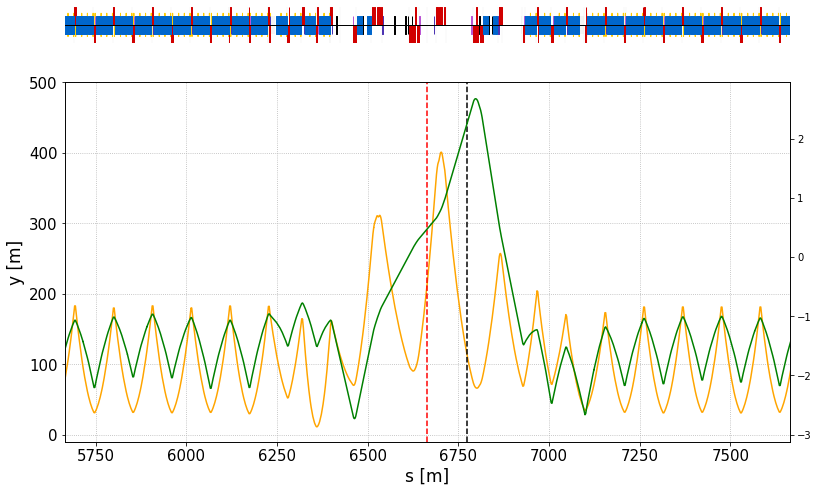

In [30]:

plot_ip_v1(df_tw_B1, IR3_s, y_lim=500)

In [31]:
d = df_tw_B1.iloc[ df_tw_B1.query('name=="mqtli.7l3.b1"').index[0] : df_tw_B1.query('name=="mq.7r3.b1"').index[0]   ]
d['name']

35163             mqtli.7l3.b1
35164        mqtli.7l3.b1_exit
35165               drift_6854
35166    mqtli.7l3.b1..2_entry
35167     mqtli.7l3.b1..2_aper
                 ...          
40347             mq.7r3.b1..1
40348        mq.7r3.b1..1_exit
40349               drift_7557
40350          mq.7r3.b1_entry
40351           mq.7r3.b1_aper
Name: name, Length: 5189, dtype: object

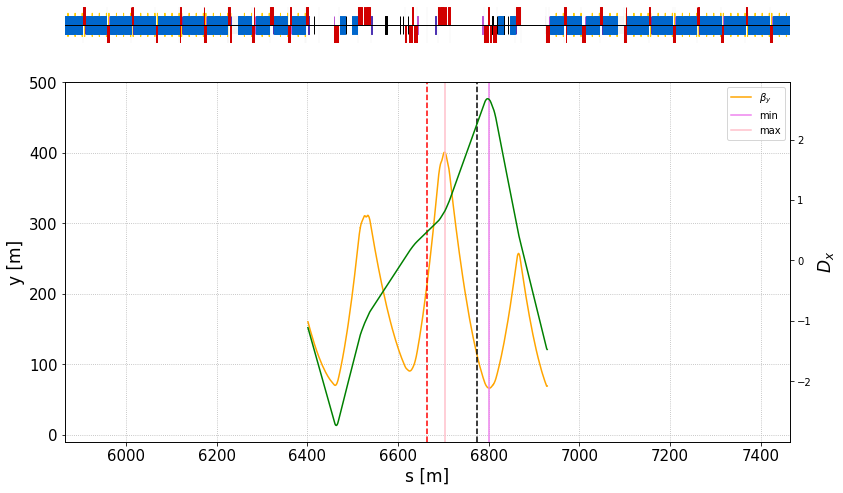

In [32]:
df = d
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
plot_ip(d, IR3_s, ax,y_lim=500)
ax[1].axvline(d.iloc[np.where(d['bety']==min(d['bety']))[0]]['s'].iloc[0], color='violet', linestyle='-', label='min')
ax[1].axvline(d.iloc[np.where(d['bety']==max(d['bety']))[0]]['s'].iloc[0], color='pink', linestyle='-', label='max')
ax[1].legend()

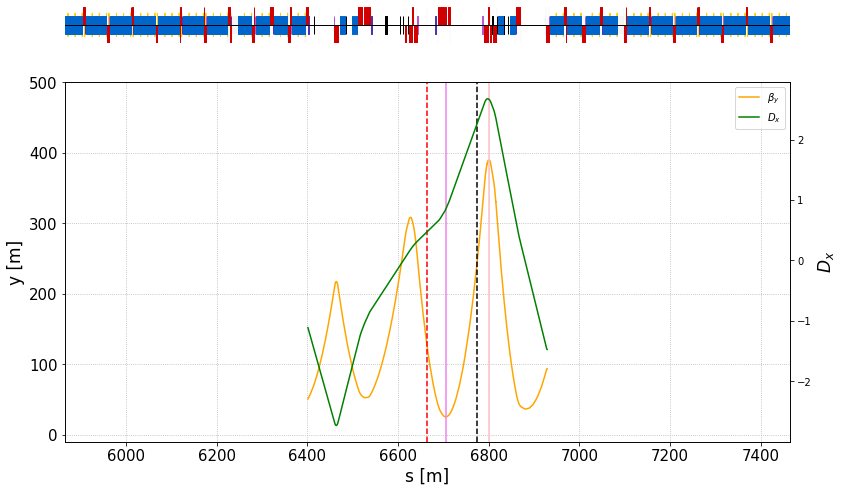

In [33]:
df = d
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
plot_ip(d, IR3_s, ax,y_lim=500, beta='betx')
ax[1].axvline(d.iloc[np.where(d['betx']==min(d['betx']))[0]]['s'].iloc[0], color='violet', linestyle='-', label='min')
ax[1].axvline(d.iloc[np.where(d['betx']==max(d['betx']))[0]]['s'].iloc[0], color='pink', linestyle='-', label='max')

In [34]:
print('max y: ', d.iloc[np.where(d['bety']==max(d['bety']))[0]]['s'].iloc[0], d.iloc[np.where(d['bety']==max(d['bety']))[0]]['name'].to_list())
print('min y: ', d.iloc[np.where(d['bety']==min(d['bety']))[0]]['s'].iloc[0], d.iloc[np.where(d['bety']==min(d['bety']))[0]]['name'].to_list())
print('max x: ', d.iloc[np.where(d['betx']==max(d['betx']))[0]]['s'].iloc[0],  d.iloc[np.where(d['betx']==max(d['betx']))[0]]['name'].to_list())
print('min x: ', d.iloc[np.where(d['betx']==min(d['betx']))[0]]['s'].iloc[0],  d.iloc[np.where(d['betx']==min(d['betx']))[0]]['name'].to_list())

max y:  6703.312596084 ['mqwa.d4r3.b1..1_entry', 'mqwa.d4r3.b1..1_aper', 'mqwa.d4r3.b1..1']
min y:  6800.871996084 ['mqwb.5r3.b1..4_entry', 'mqwb.5r3.b1..4_aper', 'mqwb.5r3.b1..4', 'mqwb.5r3.b1..4_exit', 'drift_7382']
max x:  6800.043196084 ['mqwb.5r3.b1..3_entry', 'mqwb.5r3.b1..3_aper', 'mqwb.5r3.b1..3', 'mqwb.5r3.b1..3_exit', 'drift_7381']
min x:  6704.970196083999 ['mqwa.d4r3.b1..3_entry', 'mqwa.d4r3.b1..3_aper', 'mqwa.d4r3.b1..3', 'mqwa.d4r3.b1..3_exit', 'drift_7258']


In [35]:
df_tw_B1.query('name=="tclpx.4r1.b1_upstream_aper_offset_entry"')

,name,s,x,px,y,py,zeta,delta,ptau,W_matrix,...,bx_chrom,by_chrom,ax_chrom,ay_chrom,wx_chrom,wy_chrom,ddx,ddpx,ddy,ddpy


In [36]:
df_tw_B1.iloc[ df_tw_B1.query('name=="tclpx.4r1.b1"').index[0]-15: df_tw_B1.query('name=="tclpx.4r1.b1"').index[0] +15]

,name,s,x,px,y,py,zeta,delta,ptau,W_matrix,...,bx_chrom,by_chrom,ax_chrom,ay_chrom,wx_chrom,wy_chrom,ddx,ddpx,ddy,ddpy
1215,vtctpxh.4r1.b.b1_aper_offset_exit,134.5280,0.003325,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[72.25569499314255, -4.440892098500626e-16, 0...",...,-12.655548,15.759655,-479.275353,-593.351837,479.442413,593.561092,322.979810,-3.483415,-112.440031,0.602036
1216,vtctpxh.4r1.b.b1,134.5280,0.002594,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[72.25569499314255, -4.440892098500626e-16, 0...",...,-12.655548,15.759655,-479.275353,-593.351837,479.442413,593.561092,322.979810,-3.483415,-112.440031,0.602036
1217,vtctpxh.4r1.b.b1_exit,134.5280,0.002594,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[72.25569499314255, -4.440892098500626e-16, 0...",...,-12.655548,15.759655,-479.275353,-593.351837,479.442413,593.561092,322.979810,-3.483415,-112.440031,0.602036
1218,drift_229,134.5280,0.002594,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[72.25569499314255, -4.440892098500626e-16, 0...",...,-12.655548,15.759655,-479.275353,-593.351837,479.442413,593.561092,322.979810,-3.483415,-112.440031,0.602036
1219,tclpx.4r1.b1_mken_entry,135.1140,0.002493,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[71.79808907203734, 1.3322676295501878e-15, 0...",...,-12.534527,15.961815,-479.635440,-593.391824,479.799198,593.606466,320.938613,-3.483415,-112.086257,0.602036
1220,tclpx.4r1.b1_mken_aper_offset_entry,135.1140,0.002493,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[71.79808907203734, 1.3322676295501878e-15, 0...",...,-12.534527,15.961815,-479.635440,-593.391824,479.799198,593.606466,320.938613,-3.483415,-112.086257,0.602036
1221,tclpx.4r1.b1_mken_aper,135.1140,0.001754,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[71.79808907203734, 1.3322676295501878e-15, 0...",...,-12.534527,15.961815,-479.635440,-593.391824,479.799198,593.606466,320.938613,-3.483415,-112.086257,0.602036
1222,tclpx.4r1.b1_mken_aper_offset_exit,135.1140,0.001754,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[71.79808907203734, 1.3322676295501878e-15, 0...",...,-12.534527,15.961815,-479.635440,-593.391824,479.799198,593.606466,320.938613,-3.483415,-112.086257,0.602036
1223,tclpx.4r1.b1_mken,135.1140,0.002493,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[71.79808907203734, 1.3322676295501878e-15, 0...",...,-12.534527,15.961815,-479.635440,-593.391824,479.799198,593.606466,320.938613,-3.483415,-112.086257,0.602036
1224,tclpx.4r1.b1_mken_exit,135.1140,0.002493,-0.000173,0.000001,-7.332990e-09,0.000015,0.0,0.0,"[[71.79808907203734, 1.3322676295501878e-15, 0...",...,-12.534527,15.961815,-479.635440,-593.391824,479.799198,593.606466,320.938613,-3.483415,-112.086257,0.602036


# Other plots


In [ ]:
import json
import numpy as np
from pathlib import Path
import sys
import os
import yaml
import pandas as pd
import pickle

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc
import scipy
import io 

from IPython import embed


# ---------------------------- LOADING FUNCTIONS ----------------------------

def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



def calcAction(p0,tw,ele,exn=2.5e-6,nrj=7000e9,debug=False):
    ex = exn*0.938e9/nrj
    alfx = tw.rows[ele].cols['alfx'].alfx[0]
    alfy = tw.rows[ele].cols['alfy'].alfy[0]
    betx = tw.rows[ele].cols['betx'].betx[0]
    bety = tw.rows[ele].cols['bety'].bety[0]
    xx0 = tw.rows[ele].cols['x'].x[0]
    yy0 = tw.rows[ele].cols['y'].y[0]
    pxx0 = tw.rows[ele].cols['px'].px[0]
    pyy0 = tw.rows[ele].cols['py'].py[0]
    x0 = p0.x - xx0
    y0 = p0.y - yy0
    px0 = p0.px - pxx0
    py0 = p0.py - pyy0
    jx = np.sqrt(x0**2/betx + (alfx*x0/np.sqrt(betx) + np.sqrt(betx)*px0)**2)/np.sqrt(ex)
    jy = np.sqrt(y0**2/bety + (alfy*y0/np.sqrt(bety) + np.sqrt(bety)*py0)**2)/np.sqrt(ex)

    if debug:
        print(tw.rows[ele].cols[['alfx','alfy','betx','bety','x','y','px','py']])
    return jx,jy

def plotHist(p1,p2,figdim=(20,10), nbins=200, save=False, savePath="plot", line = None, density=False,scale=1, range=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,figsize=figdim)
    ax.hist([p1*scale,p2*scale],nbins,density=density,color=['red','green'])
    if line is not None:
        if not hasattr(line, '__iter__') or isinstance(line, str):
            line = [line]
        for l in line:
            ax.axvline(x=l, color='black', linestyle='--')

    if range is not None:
        ax.set_xlim(range)
    plt.show()

def get_df_to_save(dict, num_particles, num_turns, epsilon = 0, start = False, x_dim = None, y_dim = None, jaw_L = None):

    float_variables = ['zeta', 'x', 'px', 'y', 'py', 'delta', 'p0c']
    int_variables = ['at_turn', 'particle_id', 'at_element', 'state', 'parent_particle_id']
    variables = float_variables + int_variables
    variables.remove('at_element')

    df = pd.DataFrame(dict['data'])
    var_dict = {}

    for var in variables:
        new_arr = np.array(df[var])
        new_arr = new_arr.reshape((num_particles, num_turns))
        var_dict[var] = new_arr   
    del df

    
    impact_part_dict = {}
    for key in var_dict.keys():
        impact_part_dict[key] = []

    if x_dim is not None and jaw_L is not None and y_dim is not None:

        abs_y_low = jaw_L
        abs_y_up = jaw_L + y_dim
        abs_x_low = -x_dim/2
        abs_x_up = x_dim/2

        print('x_dim', x_dim, 'y_dim', y_dim, 'jaw_L', jaw_L, num_particles, num_turns)
        for part in range(num_particles):
            for turn in range(num_turns):
                if var_dict['state'][part, turn] > 0 and var_dict['x'][part, turn] > (abs_x_low - epsilon) and var_dict['x'][part, turn] < (abs_x_up + epsilon) and var_dict['y'][part, turn] > (abs_y_low - epsilon) and var_dict['y'][part, turn] < (abs_y_up + epsilon):
                    for key in var_dict.keys():
                        impact_part_dict[key].append(var_dict[key][part, turn])

    impact_part_df = pd.DataFrame(impact_part_dict) 
    
    return impact_part_df




# -------------------------------------------------------------------------------




beam          = 2
plane         = 'V'

num_turns     = 1 #run_dict['turns'] 
num_particles = 1000000 #len(start_values)

normalized_emittance = 2.5e-6


TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TCP_name = 'tcp.d6r7.b2'

TCCS_align_angle_step = 0



coll_file = os.path.expandvars('${HOME_TWOCRYST}/input_files/colldbs/HL_tight_twocryst.yaml')




if coll_file.endswith('.yaml'):
    with open(coll_file, 'r') as stream:
        coll_dict = yaml.safe_load(stream)['collimators']['b2']
if coll_file.endswith('.data'):
    print("Please convert and use the yaml file for the collimator settings")
    sys.exit(1)
    


context = xo.ContextCpu(omp_num_threads='auto')



# ---------------------------- SETUP LINE ----------------------------
def setup_line(line_name, coll_dict=coll_dict, beam = 2, plane = 'V', num_particles = num_particles, num_turns = 1, TCCS_align_angle_step=0):

    TCCS_align_angle_step = 0
    TCCS_gap =  7.2 #7.2
    TARGET_gap = 33.6 #33.6
    TCCP_gap =  33.6 #33.6
    PIXEL_gap = 33.6  #33.6

    mode = 'target_absorber'
    turn_on_cavities = True
    engine        = 'everest'


    # Load from json
    line_file = os.path.expandvars(line_name)
    line = xt.Line.from_json(line_file)

    end_s = line.get_length()

    TCCS_name = 'tccs.5r3.b2'
    TCCP_name = 'tccp.4l3.b2'
    TARGET_name = 'target.4l3.b2'
    PIXEL_name = 'pixel.detector'
    TCP_name = 'tcp.d6r7.b2'

    d_pix = 1 # [m]
    ydim_PIXEL = 0.01408
    xdim_PIXEL = 0.04246

    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    dx = 1e-11
    TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2 + dx)
    PIXEL_loc = end_s - (6653.3 - coll_dict[TCCP_name]["length"]/2 - d_pix)
    TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]

    print('TARGET LOC: ', end_s - TARGET_loc)
    print('TCP LOC: ', end_s - TCP_loc)
    print('TCLA LOC: ', end_s -   line.get_s_position()[line.element_names.index('tcla.a5l3.b2')])


    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
    line.insert_element(at_s=PIXEL_loc, element=xt.Marker(), name=PIXEL_name)


    TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TCCP_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    PIXEL_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TCP_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    #dx = 1e-11
    line.insert_element(at_s = TCCS_loc - coll_dict[TCCS_name]["length"]/2 - dx, element=TCCS_monitor, name='TCCS_monitor')
    line.insert_element(at_s = TARGET_loc - coll_dict[TARGET_name]["length"]/2 - dx, element=TARGET_monitor, name='TARGET_monitor')
    line.insert_element(at_s = TCCP_loc - coll_dict[TCCP_name]["length"]/2 - dx/2, element=TCCP_monitor, name='TCCP_monitor')
    line.insert_element(at_s = PIXEL_loc, element=PIXEL_monitor, name='PIXEL_monitor')
    line.insert_element(at_s = TCP_loc + coll_dict[TCP_name]["length"]/2 + 1e5*dx, element=TCP_monitor, name='TCP_monitor') 

    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])

    # switch on cavities
    if turn_on_cavities:
        speed = line.particle_ref._xobject.beta0[0]*scipy.constants.c
        harmonic_number = 35640
        voltage = 12e6/len(line.get_elements_of_type(xt.Cavity)[1])
        frequency = harmonic_number * speed /line.get_length()
        for side in ['l', 'r']:
            for cell in ['a','b','c','d']:
                line[f'acsca.{cell}5{side}4.b2'].voltage = voltage
                line[f'acsca.{cell}5{side}4.b2'].frequency = frequency   

    # Aperture model check
    print('\nAperture model check on imported model:')
    df_imported = line.check_aperture()
    assert not np.any(df_imported.has_aperture_problem)


    # Initialise collmanager
    coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)

    # Install collimators into line
    if engine == 'everest':
        coll_names = coll_manager.collimator_names

        if mode == 'target_absorber': 
            black_absorbers = [TARGET_name,]
        else: 
            black_absorbers = []

        everest_colls = [name for name in coll_names if name not in black_absorbers]

        coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
        coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)
    else:
        raise ValueError(f"Unknown scattering engine {engine}!")


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

    coll_manager.build_tracker()
    coll_manager.set_openings(gaps = {TCCS_name: TCCS_gap, TCCP_name: TCCP_gap, TARGET_name: TARGET_gap})


    print("\nTCCS aligned to beam: ", line[TCCS_name].align_angle)
    #line[TTCS_name].align_angle = TTCS_align_angle_step
    print("TCCS align angle incremented by step: ", TCCS_align_angle_step)
    line[TCCS_name].align_angle = line[TCCS_name].align_angle + TCCS_align_angle_step
    print("TCCS final alignment angle: ", line[TCCS_name].align_angle)


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

    return line, coll_manager







# ---------------------------- LOAD PARTICLES ----------------------------


def select_particle(n_job = 0, part_id = 0, return_both = True):

    load_input_path = '/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7____20240319-1209'
    #load_input_path = '/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7___20240319-0931'
    input_path  = Path(load_input_path, f'Job.{n_job}/Outputdata/particles_B{beam}{plane}.h5')
    print('Particles read from: ', input_path)

    df_part = pd.read_hdf(input_path, key='initial_particles')
    dct_part = df_part.to_dict(orient='list')
    size_vars = (
        (xo.Int64, '_capacity'),
        (xo.Int64, '_num_active_particles'),
        (xo.Int64, '_num_lost_particles'),
        (xo.Int64, 'start_tracking_at_element'),
    )
    scalar_vars = (
            (xo.Float64, 'q0'),
            (xo.Float64, 'mass0'),
            (xo.Float64, 't_sim'),
        )
    for tt, nn in scalar_vars + size_vars:
        if nn in dct_part.keys() and not np.isscalar(dct_part[nn]):
                dct_part[nn] = dct_part[nn][0]
    part = xp.Particles.from_dict(dct_part, load_rng_state=True)

    p = part.filter(part.particle_id==part_id)

    if return_both:
        return p, part
    else:
        return p



part, part_job = select_particle(n_job = 99, part_id = 81904, return_both = True)

# ---------------------------- DECIDE LINES TO TRACK ----------------------------
line0_file = '${HOME_TWOCRYST}/input_files/HL_IR7_tune_changed/b4_sequence_patched_tune.json'
line1_file = '${HOME_TWOCRYST}/input_files/HL_IR7_phase_advance/b4_sequence_patched_phadv.json'

line0, coll_manager0 = setup_line(line0_file, coll_dict)
#line1, coll_manager1 = setup_line(line1_file)


# ---------------------------- GET SOME  INFRMATION ----------------------------

idx_TCP = line0.element_names.index(TCP_name)
idx_TARGET = line0.element_names.index(TARGET_name)
idx_TCCS = line0.element_names.index(TCCS_name)


# ---------------------------- TRACKING ----------------------------
part_gen = part.copy()
idx = line0.element_names.index(TCP_name)



def plot_traj(s_part, y_part, line):
    import matplotlib.pyplot as plt
    
    if not hasattr(s_part, '__iter__') or isinstance(s_part, list):
        if any(isinstance(subvar, list) for subvar in s_part):
            pass
        else:
            s_part = [s_part]
            y_part = [y_part]
    for s, y in zip(s_part,y_part):
        plt.plot(s,y)
    plt.vlines(line.get_s_elements()[idx_TCCS], -0.015, 0.015, color='k', linestyles='--')
    plt.vlines(line.get_s_elements()[idx_TARGET], -0.015, 0.015,color='k', linestyles='--')
    plt.vlines(line.get_s_elements()[idx_TCP], -0.015, 0.015,color='k', linestyles='--')
    
    plt.hlines(line.elements[idx_TCCS].jaw_L + line.elements[idx_TCCS].ref_y, line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    plt.hlines(line.elements[idx_TCCS].jaw_L + line.elements[idx_TCCS].ref_y  + coll_dict[TCCS_name]['xdim'], line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    plt.hlines(line.elements[idx_TARGET].jaw_L + line.elements[idx_TARGET].ref_y, line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    plt.hlines(line.elements[idx_TARGET].jaw_L + line.elements[idx_TARGET].ref_y  + coll_dict[TARGET_name]['xdim'], line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    ips = ['ip1', 'ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8']
    for ip in ips:
        plt.vlines( line.get_s_position()[ line.element_names.index(ip)], -0.015, 0.015,color='r', linestyles='--', alpha=0.3)
        plt.text(line.get_s_position()[line.element_names.index(ip)], 0.02, ip)

    plt.show()



def save_y_traj(line, part, idx_start, idx_stop):
    s, y= [], []
    for i in range(idx_start,idx_stop):
        line.track(part, ele_start=i, ele_stop=i+1)
        s.append(part.s[0])
        y.append(part.y[0])
    return s, y

def save_y_multiturn(line, part, idx_start, num_turns):

    def save_y_traj(line, part, idx_start, idx_stop):
        s, y= [], []
        for i in range(idx_start,idx_stop):
            line.track(part, ele_start=i, ele_stop=i+1)
            s.append(part.s[0])
            y.append(part.y[0])
        return s, y

    ss, yy = [], []
    s, y= [],[]
    final_idx = len(line.element_names)
    s, y = save_y_traj(line, part, idx_start, final_idx)
    ss.append(s[:-1])
    yy.append(y[: -1])
    t = 1
    while t < num_turns:
        s, y = save_y_traj(line, part, 0, final_idx)
        ss.append(s[:-1])
        yy.append(y[:-1])
        t = t+1
    return ss, yy

def track_turns(line, part, num_turns, idx_start = None):
    if idx_start is not None:
        line.track(part, num_turns=num_turns, ele_start=idx_start)
    else:
        line.track(part, num_turns=num_turns)

In [ ]:
tw = line0.twiss()

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(18,14))
end_s = line0.get_length()
ax[0].plot(end_s - tw.s, tw.y, label='y')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('y [m]')
ips = ['ip1', 'ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8']
for ip in ips:
    ax[0].axvline( end_s - line0.get_s_position()[ line0.element_names.index(ip)], -0.015, 15,color='r', linestyle='--', alpha=0.3)
    ax[0].text(end_s - line0.get_s_position()[line0.element_names.index(ip)], 0.015, ip)
ax[0].set_title('Closed orbit vertical')

ax[1].plot(end_s - tw.s, tw.bety, label='y')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel(r'$\beta$y [m]')
ips = ['ip1', 'ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8']
for ip in ips:
    ax[1].axvline( end_s - line0.get_s_position()[ line0.element_names.index(ip)], 0, 16500, color='r', linestyle='--', alpha=0.3)
    ax[1].text(end_s - line0.get_s_position()[line0.element_names.index(ip)], 16500, ip)
ax[1].set_title('Beta function vertical')
plt.savefig('./Plots/HL_startingline.png')